# MACD

[*********************100%***********************]  1 of 1 completed


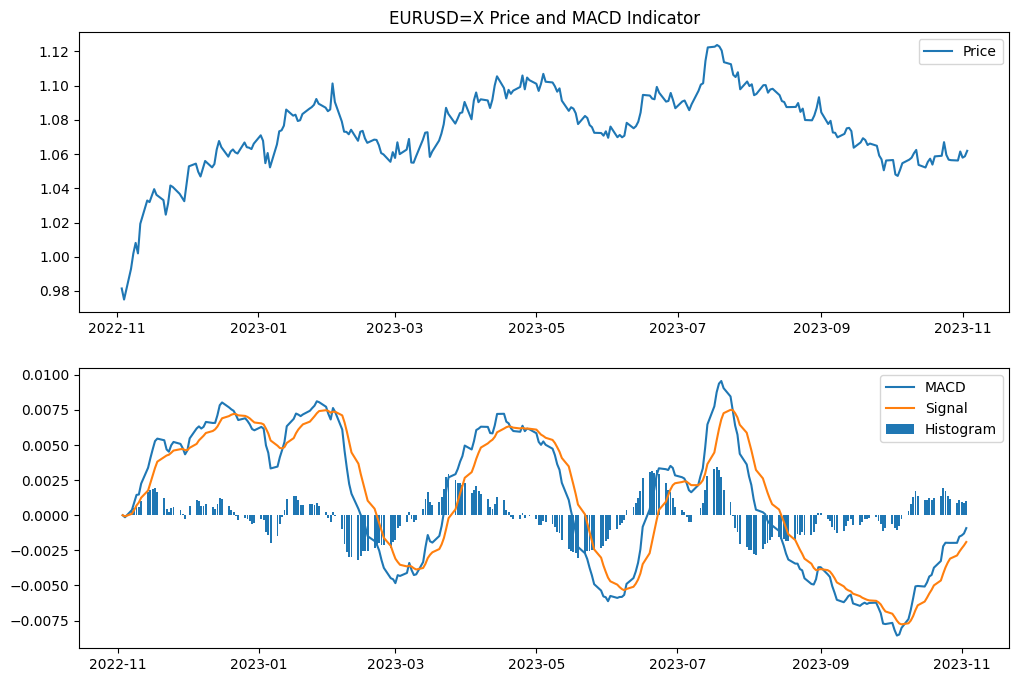

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Define the forex pair and the time period
pair = "EURUSD=X"
period = "1y"

# Download the historical data from Yahoo Finance
data = yf.download(pair, period=period)

# Calculate the MACD line, the signal line, and the histogram
data["MACD"] = data["Close"].ewm(span=12).mean() - data["Close"].ewm(span=26).mean()
data["Signal"] = data["MACD"].ewm(span=9).mean()
data["Histogram"] = data["MACD"] - data["Signal"]

# Plot the price and the MACD indicator
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(data["Close"], label="Price")
plt.title(pair + " Price and MACD Indicator")
plt.legend()
plt.subplot(2,1,2)
plt.plot(data["MACD"], label="MACD")
plt.plot(data["Signal"], label="Signal")
plt.bar(data.index, data["Histogram"], label="Histogram")
plt.legend()
plt.show()


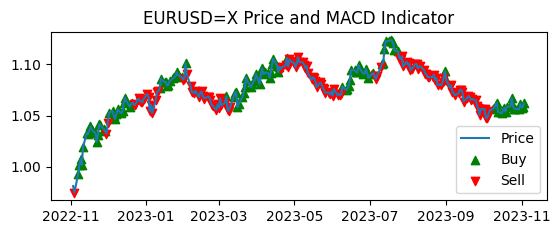

In [2]:
# Find the crossover points of the MACD line and the signal line
data["Crossover"] = data["MACD"] - data["Signal"]
data["Buy"] = data["Crossover"].apply(lambda x: 1 if x > 0 else 0)
data["Sell"] = data["Crossover"].apply(lambda x: -1 if x < 0 else 0)

# Plot the buy and sell signals on the price chart
plt.subplot(2,1,1)
plt.plot(data["Close"], label="Price")
plt.scatter(data.index, data["Close"].where(data["Buy"] == 1), marker="^", color="green", label="Buy")
plt.scatter(data.index, data["Close"].where(data["Sell"] == -1), marker="v", color="red", label="Sell")
plt.title(pair + " Price and MACD Indicator")
plt.legend()


# MACD and ICT

[*********************100%***********************]  1 of 1 completed


C:\Users\nuruj\AppData\Local\Temp\ipykernel_7076\651006343.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if extrema[i] != 0:
C:\Users\nuruj\AppData\Local\Temp\ipykernel_7076\651006343.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  swings.append(extrema[i])
C:\Users\nuruj\AppData\Local\Temp\ipykernel_7076\651006343.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prev_low = data["Close"][i-1]
C:\Users\nuruj\AppData\L

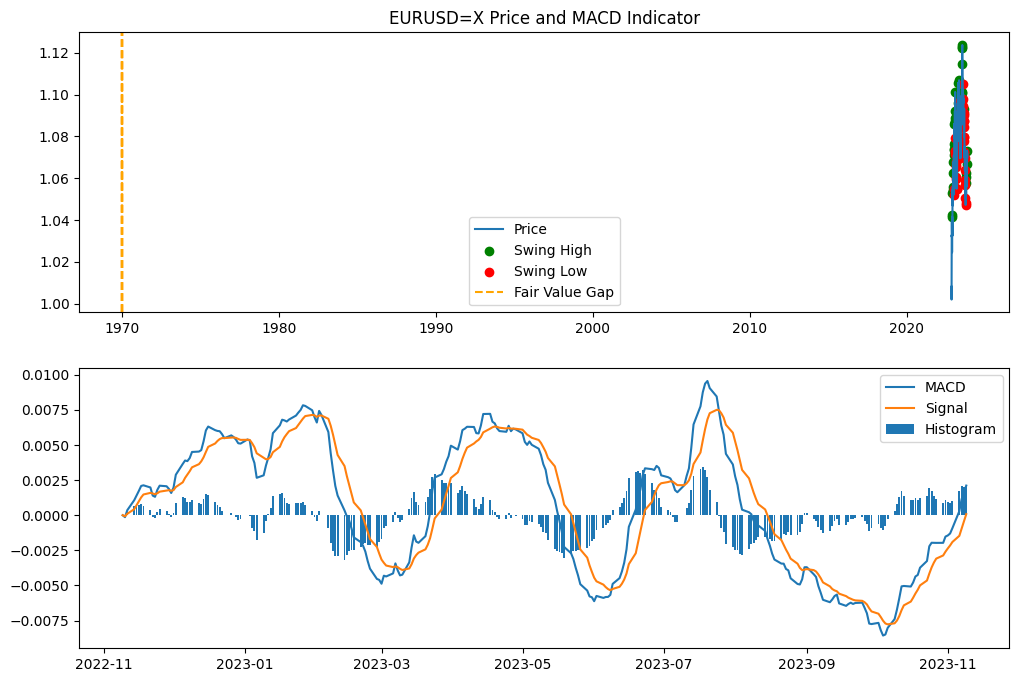

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np

# Define the forex pair and the time period
pair = "EURUSD=X"
period = "1y"

# Download the historical data from Yahoo Finance
data = yf.download(pair, period=period)

# Calculate the MACD line, the signal line, and the histogram
data["MACD"] = data["Close"].ewm(span=12).mean() - data["Close"].ewm(span=26).mean()
data["Signal"] = data["MACD"].ewm(span=9).mean()
data["Histogram"] = data["MACD"] - data["Signal"]

# Define a function to find the local extrema
def find_extrema(data, window):
    # Find the local maxima and minima within a rolling window
    data["Max"] = data["Close"].rolling(window).max()
    data["Min"] = data["Close"].rolling(window).min()
    # Mark the extrema as 1 or -1, and the rest as 0
    data["Extrema"] = np.where(data["Close"] == data["Max"], 1, np.where(data["Close"] == data["Min"], -1, 0))
    # Return the extrema column
    return data["Extrema"]

# Define a function to find the swing points
def find_swings(data, extrema):
    # Initialize an empty list to store the swing points
    swings = []
    # Loop through the extrema values
    for i in range(len(extrema)):
        # If the current value is not zero, append it to the list
        if extrema[i] != 0:
            swings.append(extrema[i])
            # If the list has more than one element, check the last two elements
            if len(swings) > 1:
                # If the last two elements have the same sign, remove the second last element
                if swings[-1] * swings[-2] > 0:
                    swings.pop(-2)
    # Return the list of swing points
    return swings

# Define a function to find the fair value gaps
def find_fvg(data, swings):
    # Initialize an empty list to store the fair value gaps
    fvg = []
    # Loop through the swing points
    for i in range(len(swings)):
        # If the current swing point is a high, find the previous low
        if swings[i] == 1:
            prev_low = data["Close"][i-1]
            # Loop backward from the current high to find the first close below the previous low
            for j in range(i, -1, -1):
                if data["Close"][j] < prev_low:
                    # Append the index and the value of the fair value gap to the list
                    fvg.append((j, data["Close"][j]))
                    break
        # If the current swing point is a low, find the previous high
        elif swings[i] == -1:
            prev_high = data["Close"][i-1]
            # Loop backward from the current low to find the first close above the previous high
            for j in range(i, -1, -1):
                if data["Close"][j] > prev_high:
                    # Append the index and the value of the fair value gap to the list
                    fvg.append((j, data["Close"][j]))
                    break
    # Return the list of fair value gaps
    return fvg

# Define a function to find the order blocks
def find_ob(data, swings):
    # Initialize an empty list to store the order blocks
    ob = []
    # Loop through the swing points
    for i in range(len(swings)):
        # If the current swing point is a high, find the previous low
        if swings[i] == 1:
            prev_low = data["Close"][i-1]
            # Loop backward from the current high to find the first bullish candle above the previous low
            for j in range(i, -1, -1):
                if data["Close"][j] > data["Open"][j] and data["Close"][j] > prev_low:
                    # Append the index and the value of the order block to the list
                    ob.append((j, data["Close"][j]))
                    break
        # If the current swing point is a low, find the previous high
        elif swings[i] == -1:
            prev_high = data["Close"][i-1]
            # Loop backward from the current low to find the first bearish candle below the previous high
            for j in range(i, -1, -1):
                if data["Close"][j] < data["Open"][j] and data["Close"][j] < prev_high:
                    # Append the index and the value of the order block to the list
                    ob.append((j, data["Close"][j]))
                    break
    # Return the list of order blocks
    return ob

# Apply the functions to the data
data["Extrema"] = find_extrema(data, 10)
swings = find_swings(data, data["Extrema"])
fvg = find_fvg(data, swings)
ob = find_ob(data, swings)

# Plot the price and the MACD indicator
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(data["Close"], label="Price")
plt.title(pair + " Price and MACD Indicator")
plt.legend()
# Plot the swing highs and lows
plt.scatter(data.index, data["Close"].where(data["Extrema"] == 1), color="green", label="Swing High")
plt.scatter(data.index, data["Close"].where(data["Extrema"] == -1), color="red", label="Swing Low")
plt.legend()
# Plot the fair value gaps
for i in range(len(fvg)):
    plt.axvline(x=fvg[i][0], color="orange", linestyle="--", label="Fair Value Gap" if i == 0 else "")
plt.legend()
# Plot the order blocks
for i in range(len(ob)):
    plt.axvline(x=ob[i][0], color="purple", linestyle=":", label="Order Block" if i == 0 else "")
plt.legend()
plt.subplot(2,1,2)
plt.plot(data["MACD"], label="MACD")
plt.plot(data["Signal"], label="Signal")
plt.bar(data.index, data["Histogram"], label="Histogram")
plt.legend()
plt.show()


# SMI

[*********************100%***********************]  1 of 1 completed


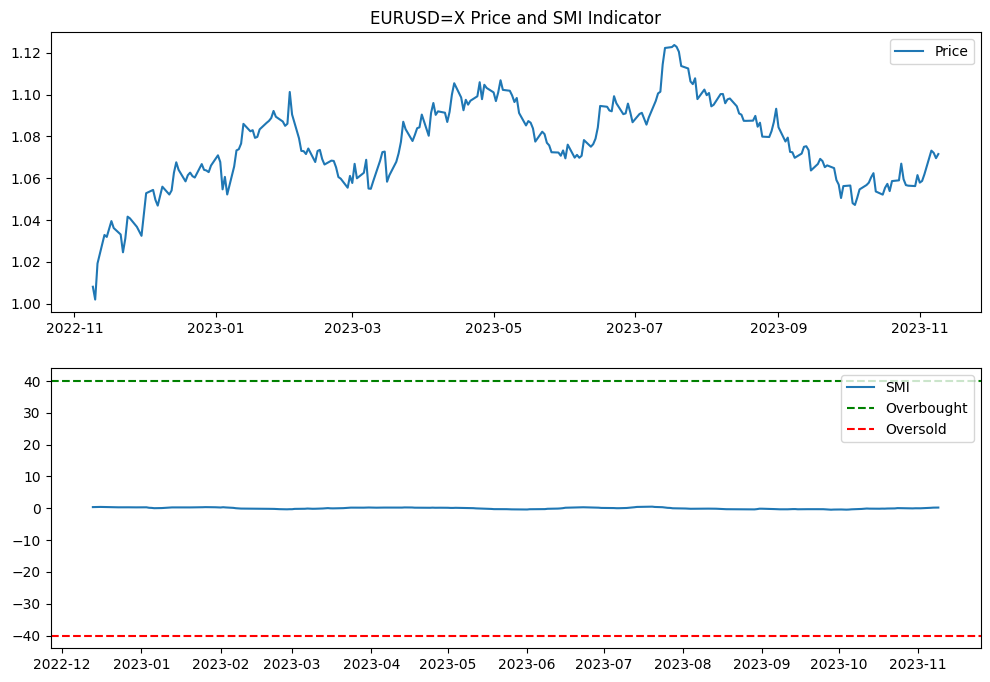

In [11]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import talib
import pandas_ta

# Define the forex pair and the time period
pair = "EURUSD=X"
period = "1y"

# Download the historical data from Yahoo Finance
data = yf.download(pair, period=period)

# Calculate the SMI indicator with default parameters
data["SMI"] = pandas_ta.momentum.smi(data["Close"], fast=5, slow=20, signal=5)["SMI_5_20_5"]

# Plot the price and the SMI indicator
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(data["Close"], label="Price")
plt.title(pair + " Price and SMI Indicator")
plt.legend()
plt.subplot(2,1,2)
plt.plot(data["SMI"], label="SMI")
plt.axhline(y=40, color="green", linestyle="--", label="Overbought")
plt.axhline(y=-40, color="red", linestyle="--", label="Oversold")
plt.legend()
plt.show()


In [17]:
data['SMI'].unique()

array([            nan,  3.70091928e-01,  3.98886998e-01,  4.33940131e-01,
        4.25123560e-01,  3.72372688e-01,  3.50979421e-01,  3.42427325e-01,
        3.21831160e-01,  3.01855361e-01,  3.20986172e-01,  3.06378601e-01,
        2.93846477e-01,  2.77162737e-01,  2.85339283e-01,  3.20663883e-01,
        3.05744941e-01,  1.58480119e-01,  1.18737864e-01,  2.96954332e-02,
        6.89950924e-02,  1.32530262e-01,  1.70724425e-01,  2.07189535e-01,
        2.73152844e-01,  2.85254937e-01,  2.95144348e-01,  2.71657434e-01,
        2.58581790e-01,  2.68149747e-01,  2.90395335e-01,  3.09771417e-01,
        3.30103909e-01,  3.61846917e-01,  3.51055980e-01,  3.17301867e-01,
        2.71040142e-01,  2.47791974e-01,  3.32964539e-01,  2.63777956e-01,
        1.29021962e-01,  1.69054493e-02, -4.61863534e-02, -9.32249092e-02,
       -1.03332864e-01, -1.48719245e-01, -1.35321004e-01, -1.22857346e-01,
       -1.42208103e-01, -1.70533817e-01, -1.72276388e-01, -1.74614449e-01,
       -1.96932675e-01, -

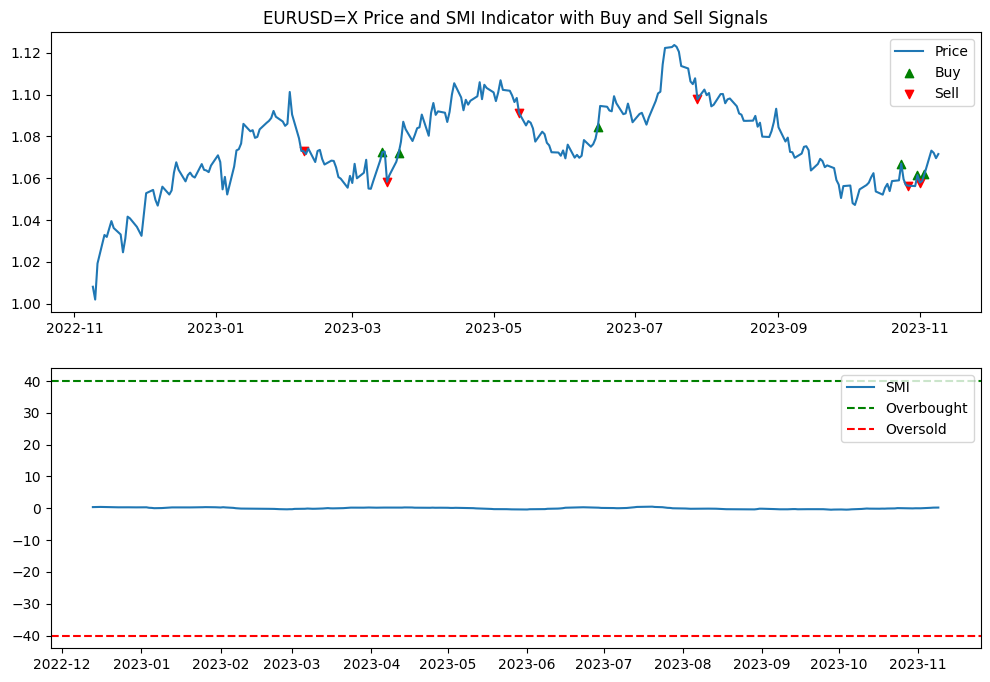

In [13]:
# Define the buy and sell signals
data["Buy"] = np.where((data["SMI"] > 0) & (data["SMI"].shift(1) < 0), 1, 0)
data["Sell"] = np.where((data["SMI"] < 0) & (data["SMI"].shift(1) > 0), 1, 0)

# Plot the price and the SMI indicator with the buy and sell signals
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(data["Close"], label="Price")
plt.title(pair + " Price and SMI Indicator with Buy and Sell Signals")
plt.legend()
plt.scatter(data.index, data["Close"].where(data["Buy"] == 1), color="green", label="Buy", marker="^")
plt.scatter(data.index, data["Close"].where(data["Sell"] == 1), color="red", label="Sell", marker="v")
plt.legend()
plt.subplot(2,1,2)
plt.plot(data["SMI"], label="SMI")
plt.axhline(y=40, color="green", linestyle="--", label="Overbought")
plt.axhline(y=-40, color="red", linestyle="--", label="Oversold")
plt.legend()
plt.show()


In [16]:
data['SMI'][10]

C:\Users\nuruj\AppData\Local\Temp\ipykernel_7076\3719722484.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['SMI'][10]


nan

# 200 EMA

[*********************100%***********************]  1 of 1 completed


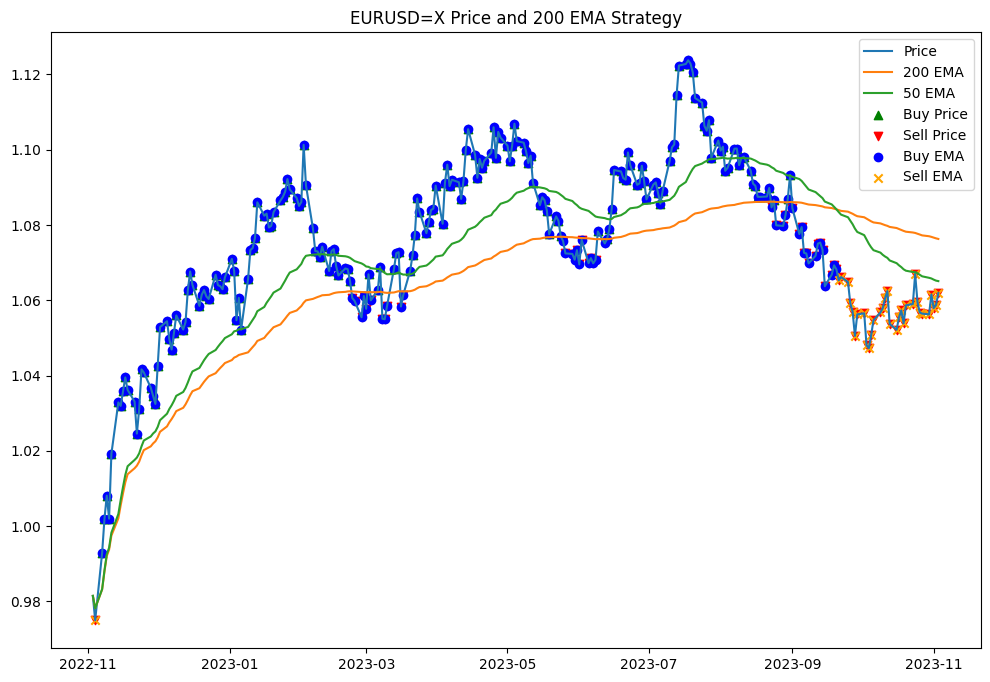

In [3]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Define the forex pair and the time period
pair = "EURUSD=X"
period = "1y"

# Download the historical data from Yahoo Finance
data = yf.download(pair, period=period)

# Calculate the 200 EMA and the 50 EMA
data["200 EMA"] = data["Close"].ewm(span=200).mean()
data["50 EMA"] = data["Close"].ewm(span=50).mean()

# Find the crossover points of the price and the 200 EMA
data["Price Crossover"] = data["Close"] - data["200 EMA"]
data["Buy Price"] = data["Price Crossover"].apply(lambda x: 1 if x > 0 else 0)
data["Sell Price"] = data["Price Crossover"].apply(lambda x: -1 if x < 0 else 0)

# Find the crossover points of the 50 EMA and the 200 EMA
data["EMA Crossover"] = data["50 EMA"] - data["200 EMA"]
data["Buy EMA"] = data["EMA Crossover"].apply(lambda x: 1 if x > 0 else 0)
data["Sell EMA"] = data["EMA Crossover"].apply(lambda x: -1 if x < 0 else 0)

# Plot the price, the 200 EMA, the 50 EMA, and the crossover signals
plt.figure(figsize=(12,8))
plt.plot(data["Close"], label="Price")
plt.plot(data["200 EMA"], label="200 EMA")
plt.plot(data["50 EMA"], label="50 EMA")
plt.scatter(data.index, data["Close"].where(data["Buy Price"] == 1), marker="^", color="green", label="Buy Price")
plt.scatter(data.index, data["Close"].where(data["Sell Price"] == -1), marker="v", color="red", label="Sell Price")
plt.scatter(data.index, data["Close"].where(data["Buy EMA"] == 1), marker="o", color="blue", label="Buy EMA")
plt.scatter(data.index, data["Close"].where(data["Sell EMA"] == -1), marker="x", color="orange", label="Sell EMA")
plt.title(pair + " Price and 200 EMA Strategy")
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed


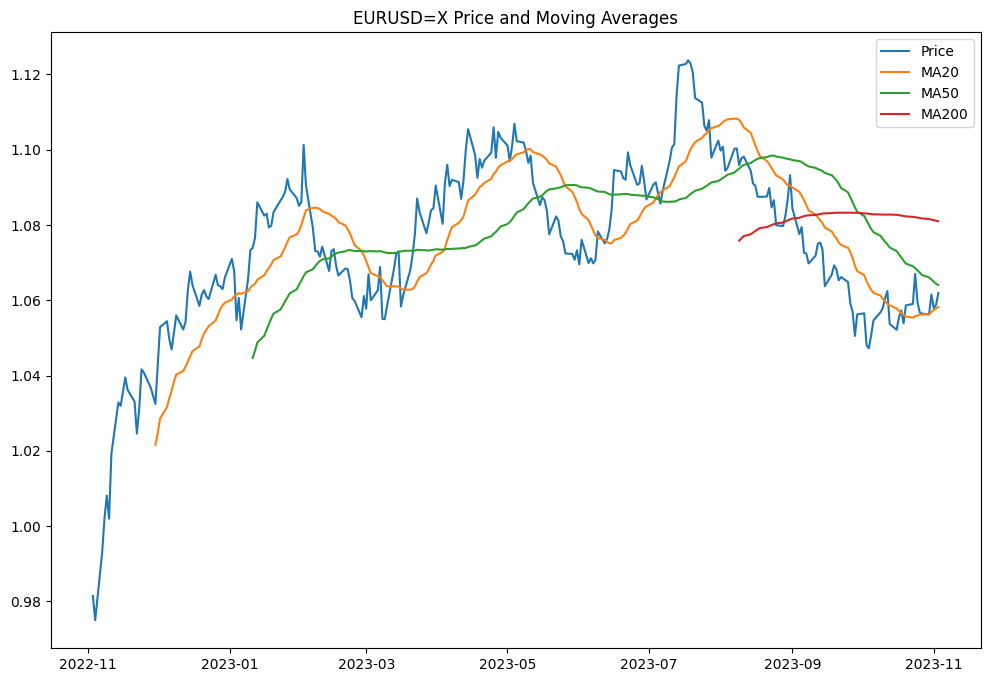

In [5]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Define the stock symbol and the time period
symbol = "EURUSD=X"
period = "1y"

# Download the historical data from Yahoo Finance
data = yf.download(symbol, period=period)

# Calculate the moving averages of the closing prices
data["MA20"] = data["Close"].rolling(20).mean()
data["MA50"] = data["Close"].rolling(50).mean()
data["MA200"] = data["Close"].rolling(200).mean()

# Plot the closing prices and the moving averages
plt.figure(figsize=(12,8))
plt.plot(data["Close"], label="Price")
plt.plot(data["MA20"], label="MA20")
plt.plot(data["MA50"], label="MA50")
plt.plot(data["MA200"], label="MA200")
plt.title(symbol + " Price and Moving Averages")
plt.legend()
plt.show()


False
False
False
False
(149956, 16, 11)
(149956, 1)
Epoch 1/25
180/180 [==============================] - 7s 24ms/step - loss: 0.0487 - mae: 0.1628 - mse: 0.0487 - val_loss: 0.0093 - val_mae: 0.0764 - val_mse: 0.0093
Epoch 2/25
180/180 [==============================] - 4s 21ms/step - loss: 0.0215 - mae: 0.1084 - mse: 0.0215 - val_loss: 0.0054 - val_mae: 0.0569 - val_mse: 0.0054
Epoch 3/25
180/180 [==============================] - 4s 21ms/step - loss: 0.0168 - mae: 0.0950 - mse: 0.0168 - val_loss: 0.0050 - val_mae: 0.0552 - val_mse: 0.0050
Epoch 4/25
180/180 [==============================] - 4s 21ms/step - loss: 0.0148 - mae: 0.0888 - mse: 0.0148 - val_loss: 0.0042 - val_mae: 0.0507 - val_mse: 0.0042
Epoch 5/25
180/180 [==============================] - 4s 21ms/step - loss: 0.0139 - mae: 0.0855 - mse: 0.0139 - val_loss: 0.0040 - val_mae: 0.0498 - val_mse: 0.0040
Epoch 6/25
180/180 [==============================] - 4s 21ms/step - loss: 0.0134 - mae: 0.0838 - mse: 0.0134 - val_loss: 

C:\Users\nuruj\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


938/938 [==============================] - 2s 2ms/step


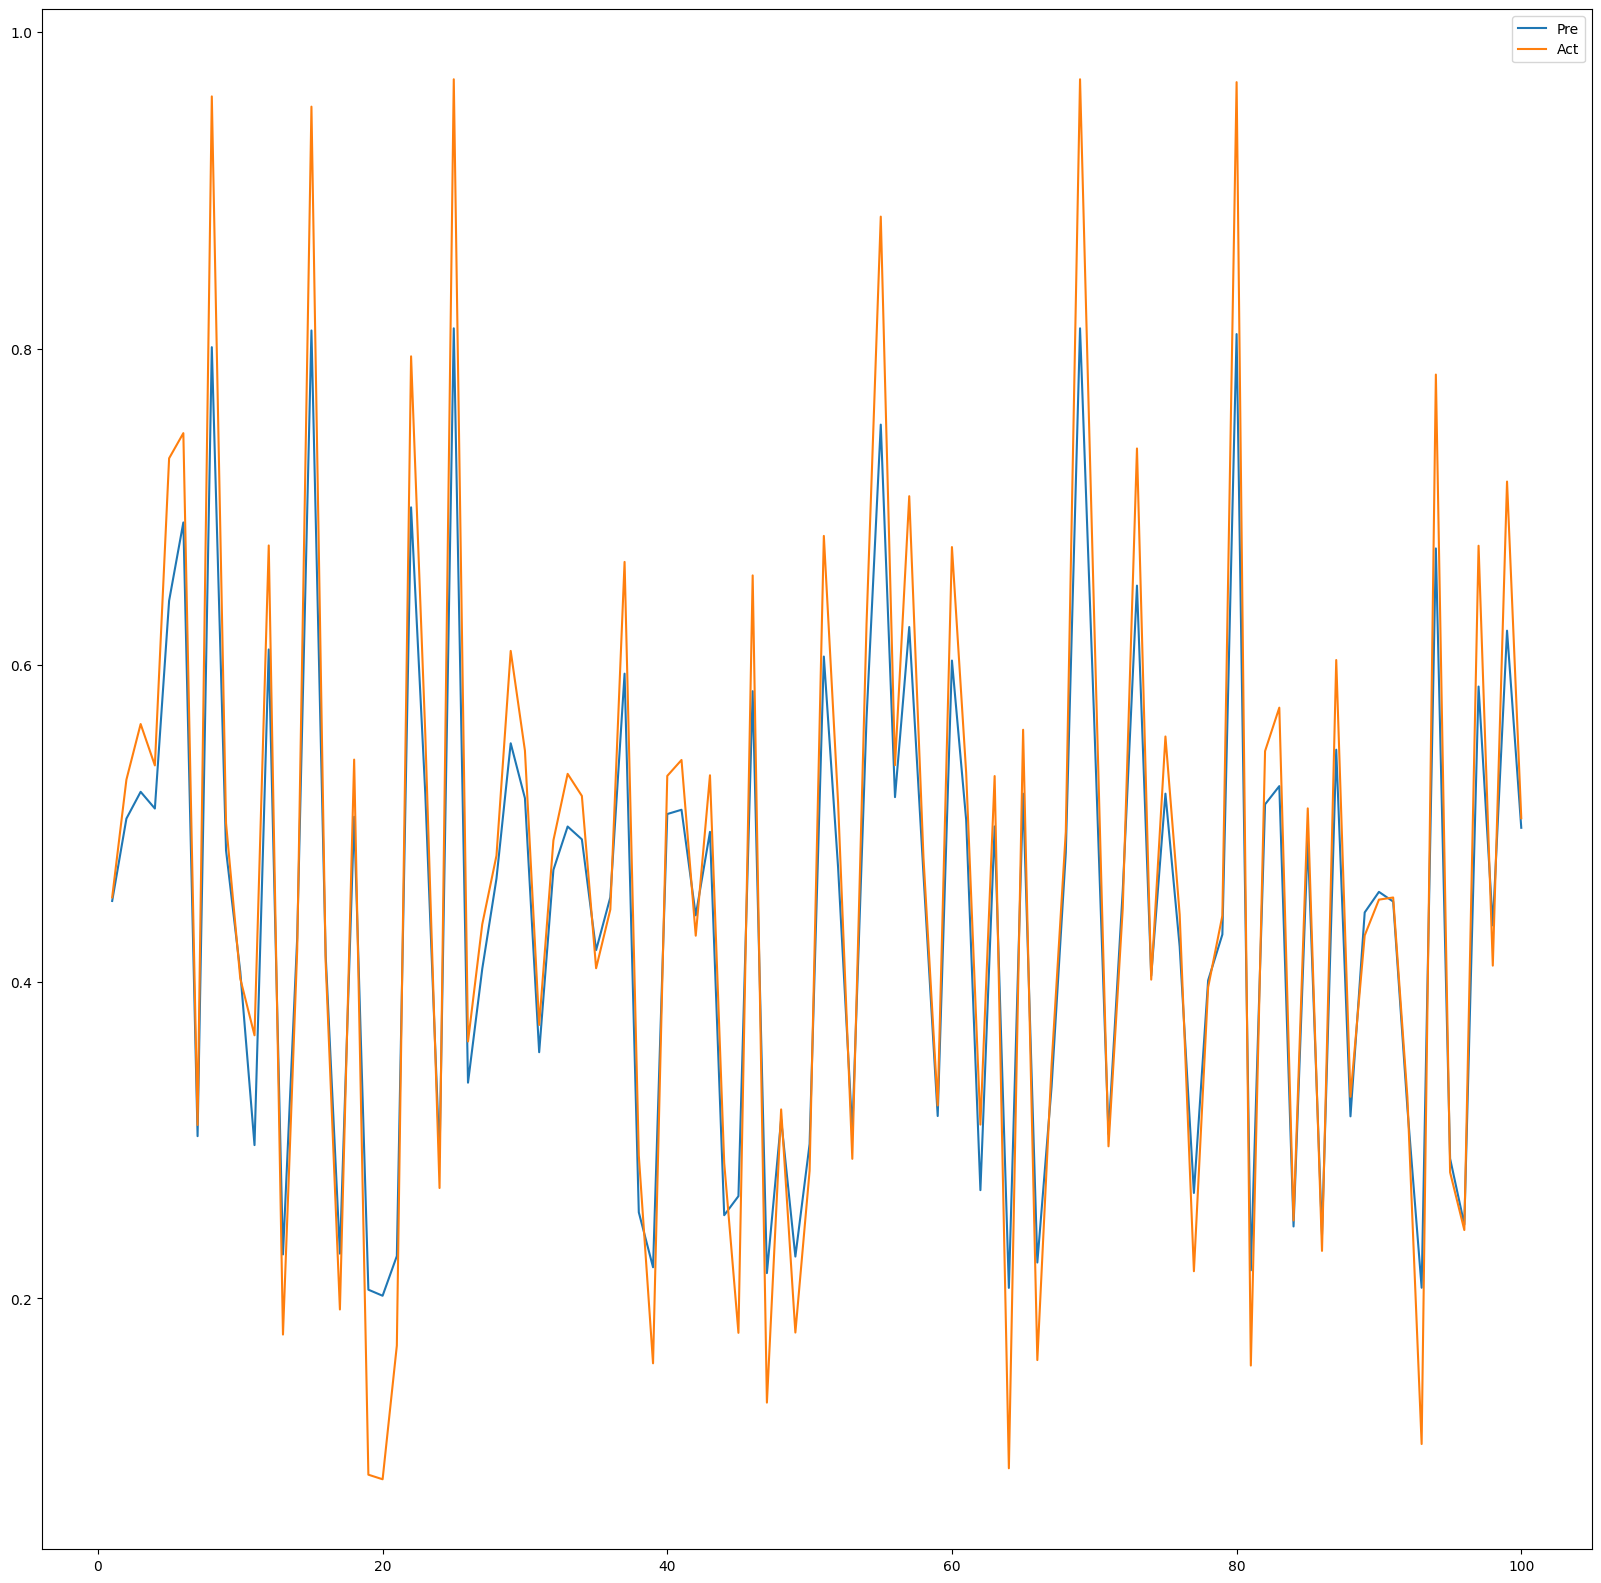

In [12]:
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Dense,Dropout,LSTM
from tensorflow.keras.models import Sequential
# from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
# from tensorflow.keras.metrics import MeanAbsolutePercentageError
from sklearn.preprocessing import MinMaxScaler
import talib


data = pd.read_csv('EURUSD_1.csv')

scaler = MinMaxScaler()
scaler_y = MinMaxScaler()
data['ROC'] = talib.RSI(data.Close,timeperiod=10)
data['ROCP'] = talib.ROCP(data.Close, timeperiod=10)
data['EMA-9'] = talib.EMA(data.Close,timeperiod=9)
data['EMA-28']= talib.EMA(data.Close,timeperiod=28)
data['SAR'] = talib.SAR(data.High, data.Low, acceleration=0, maximum=0.2)
data['upperband'], data['middleband'], data['lowerband'] = talib.BBANDS(data.Close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
data['Real'] = talib.TRANGE(data.High, data.Low, data.Close)
# data = scaler.fit_transform(data)
# data = pd.DataFrame(data,columns=['High','Low','Close'])
data['mean']=(data.High+data.Low)/2
data.drop(labels=['Open','Gmt time','Volume','High','Low'],axis=1,inplace=True)
data.dropna(inplace=True)
lable= data.Close.shift(periods=-17)
data.replace([np.inf, -np.inf],0,inplace=True)
data = scaler.fit_transform(data)
data = pd.DataFrame(data)
y = [i for i in lable if str(i) != 'nan']
y=np.array(y,dtype=np.float64)
y = scaler_y.fit_transform(y.reshape(-1,1))
# print(data.head())
x=[]
for i in range(16,len(data)+1):
    x.append(data.iloc[i-16:i].values)
x = x[:len(y)]
x = np.array(x,dtype=np.float64)
print(np.any(np.isnan(x)))
print(np.any(np.isinf(x)))
print(np.any(np.isnan(y)))
print(np.any(np.isinf(y)))

X_train_merged, X_val_and_test, Y_train_merged, Y_val_and_test = train_test_split(x, y, test_size=0.4)

X_val_merged, X_test_merged, Y_val_merged, Y_test_merged = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)
print(x.shape)
print(y.shape)

model = Sequential()
model.add(LSTM(16,return_sequences=True,activation='relu',input_shape=(16,11)))
model.add(Dropout(0.3))
model.add(LSTM(16,return_sequences=True))
model.add(Dropout(0.3))
model.add(Dense(8,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam',
                loss='mse',
                metrics=['mae','mse'])
model.fit(x=X_train_merged, y=Y_train_merged, epochs=25,batch_size=500,validation_data=(X_val_merged,Y_val_merged))

model.save('models/model3.h5')

import matplotlib.pyplot as plt


out = model.predict(X_test_merged)
o = []
for i in out:
    o.append(i[0])

plt.figure(figsize=(20,20))
plt.plot(range(1,101),o[:100])
plt.plot(range(1,101),Y_test_merged[:100])
# plt.plot(Y_test_merged)

plt.legend(["Pre", "Act"])

plt.show()

In [17]:
from LinearRegressionForecast import LinearRegressionForecast

forecast = LinearRegressionForecast("EURUSD", "2023-11-01", "2023-11-30")
High = forecast.run_prediction("High")
Low = forecast.run_prediction("Low")
Close = forecast.run_prediction("Close")

print(High[0], Low[0], Close[0])

[*********************100%***********************]  1 of 1 completed
EURUSD=X Price (y) = 0.00 * 3 Moving Average (x1)         + 0.00 * 9 Moving Average (x2)         + 1.07 (constant)


C:\Users\nuruj\anaconda3\envs\trader\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\nuruj\Desktop\Trade\LinearRegressionForecast.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MA7'] = data[self.strategy].rolling(window=self.roll).mean()
C:\Users\nuruj\Desktop\Trade\LinearRegressionForecast.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MA9']

[*********************100%***********************]  1 of 1 completed
EURUSD=X Price (y) = 0.00 * 3 Moving Average (x1)         + 0.00 * 9 Moving Average (x2)         + 1.06 (constant)


C:\Users\nuruj\anaconda3\envs\trader\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\nuruj\Desktop\Trade\LinearRegressionForecast.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MA7'] = data[self.strategy].rolling(window=self.roll).mean()
C:\Users\nuruj\Desktop\Trade\LinearRegressionForecast.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MA9']

[*********************100%***********************]  1 of 1 completed
EURUSD=X Price (y) = 0.00 * 3 Moving Average (x1)         + 0.00 * 9 Moving Average (x2)         + 1.06 (constant)
                Open      High       Low     Close  Volume       MA7  \
Date                                                                   
2023-11-01  1.057910  1.058078  1.052288  1.057910       0  1.058078   
2023-11-02  1.058705  1.067008  1.058425  1.058705       0  1.067008   

                 MA9  predicted_price direction  
Date                                             
2023-11-01  1.058078         1.067008      Sell  
2023-11-02  1.067008         1.067008      Sell                   Open      High       Low     Close  Volume       MA7  \
Date                                                                   
2023-11-01  1.057910  1.058078  1.052288  1.057910       0  1.052288   
2023-11-02  1.058705  1.067008  1.058425  1.058705       0  1.058425   

                 MA9  predicted_price 

C:\Users\nuruj\anaconda3\envs\trader\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\nuruj\Desktop\Trade\LinearRegressionForecast.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MA7'] = data[self.strategy].rolling(window=self.roll).mean()
C:\Users\nuruj\Desktop\Trade\LinearRegressionForecast.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MA9']

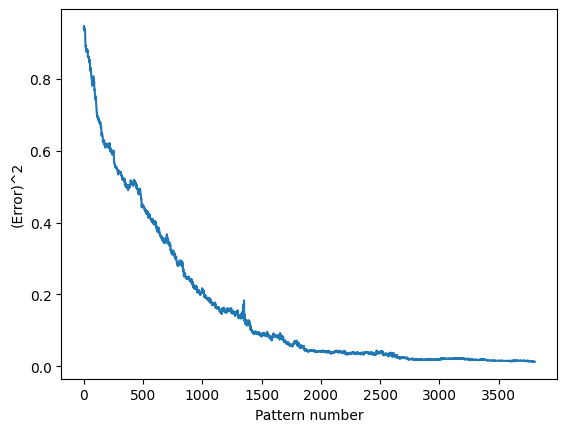

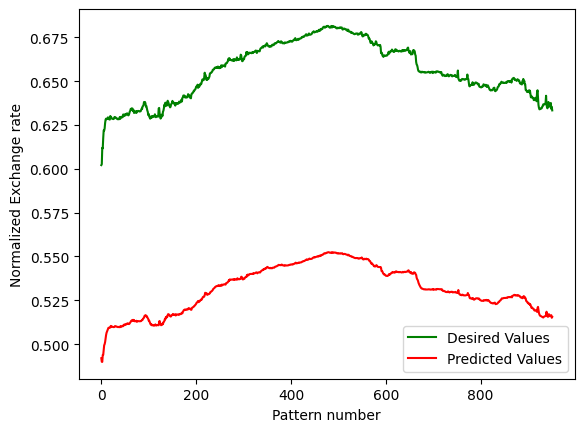

In [8]:
# import necessary libraries

import sys

import matplotlib.pyplot as plt
import pandas as pd

# import necessary modules

sys.path.append("Adaptive filters")
sys.path.append("Feature extractors")

from lms import lms
from feature_extractior_functions import simple_amv_extractor
from normalization_functions import simple_normalize

# import dataset
dataset = pd.read_csv('data.csv')
data = list(dataset['Price'].values)

# =====================================================================================================================
# ===== Helper functions ==============================================================================================
# =====================================================================================================================

def predict(inputs, weights):
    '''
    Model to predict the exchange rate based on inputs and weights

    This function takes in features as input, in this case the features are actual value, mean value, and variance, and
    then the features are multiplied with its respective weight and added up to compute the predicted value.
    Mathematically: y_k = a*w0 + m*w1 + v*w2

    :param inputs: (list) containing features of the dataset
    :param weights: (list) containing weights for each feature of the dataset
    :return: (float) predicted outcome based on input and weights
    '''
    return sum([i * j for i, j in zip(inputs, weights)])


def plot_convergence_characteristics(errors):
    '''
    Function to plot the convergence characteristics viz. plot of (error)^2 v/s pattern number

    Convergence characteristics shows the rate of convergence of the error of prediction v/s actual value, to 0.

    :param errors: (list) containing errors corresponding to each pattern
    :return: none
    '''
    errors_squared = [i * i for i in errors]
    plt.plot(errors_squared)
    plt.xlabel('Pattern number')
    plt.ylabel('(Error)^2')
    plt.show()


# =====================================================================================================================
# ===== Forecast Algorithm ============================================================================================
# =====================================================================================================================

# first we normalize the data, we use simple normalization technique of dividing each value in data by max value of data
n_data = simple_normalize(data)

# define window size
window_size = 10

# extract the feature-patterns (a,m,v,tv) from the data, and store it in a list
feature_table = simple_amv_extractor(window_size, n_data[:(len(n_data) - 1)])

# We will be using 80% of the feature-patterns from the feature table for training the model, and the remaining 20% of
# the feature-patters will be used for testing the model

# separating training data and test data and storing them in respective lists for later use
training_data = feature_table[:int(len(feature_table) * 0.8)]
testing_data = feature_table[int(len(feature_table) * 0.8):]


# Now that the data is ready, we train our model to compute optimum weights

# Model trainer
def train_model(training_data, mu):
    '''
    This function trains the prediction model to find the optimum weights for which prediction error is minimum

    Algorithm: Initially the model starts with weights = [0,0,0], the model then predicts some value, then it computes
    error vs the actual value/desired value and adjusts the weights accordingly. This is repeated until all patterns in
    the training set are exhausted. At the end, the error should have converged to zero, this can be seen in the
    convergence characteristics plot generated at the end of training.
    NOTE: The convergence of error is highly dependent on the choice of 'mu' - the convergence coefficient.
    Theoretically, its value should lie between 0 and 1, when mu is closer towards zero learning rate will be slow,
    but accuracy will be more, when it is closer to 1, learning rate will be faster, but accuracy will be poor.

    :param training_data: (list) containing features selected to train the model
    :param mu: (float) convergence coeffecient
    :return: (list) containing optimized weights, which can be used for prediction
    '''

    # This list will store weights, initially the weights will be zeros
    weights = [0, 0, 0]
    # This list will store errors corresponding to each pattern
    errors = []

    # This loop optimizes the weights, such that error converges to zero
    for i in training_data:
        # Inputs to the predictor model [a, m, v]
        x_k = i[:len(i) - 1]
        # Desired value or target value, that is to be predicted
        d_k = i[len(i) - 1]
        # Predict the output price based on the input and current weights
        y_k = predict(x_k, weights)
        # Compare the predicted price to the desired price, and compute the error
        e_k = d_k - y_k
        # Store the error to the list
        errors.append(e_k)
        # Compute new weights based on the previous weights, mu, previous input, previous error using lms algorithm
        weights = lms(weights, mu, x_k, e_k)

    plot_convergence_characteristics(errors)
    return weights


weights = train_model(training_data, 0.000195)


# Now that we have computed the optimum weights, we test it against the feature-patterns that we had stored earlier

# start testing
def test_model(testing_data, weights):
    '''
    This function tests the performance of the model so that we can know the accuracy of the model

    :param testing_data: (list) containing features that are to be tested
    :param weights: (list) containing optimum weights generated during training
    :return: none
    '''

    # Lists to store errors, desired/target value, and predicted value for each test-pattern
    errors = []
    desired = []
    predicted = []

    # This loop predicts a value for each pattern, computes error against desired value and stores them in lists above
    for i in testing_data:
        # Inputs to the predictor model
        x_k = i[:len(i) - 1]
        # Desired value or target value, that is to be predicted
        d_k = i[len(i) - 1]
        # Predict the output price based on the input and optimum weights generated during training
        y_k = predict(x_k, weights)
        # Store the predicted value and desired value to the respectivs lists
        predicted.append(y_k)
        desired.append(d_k)
        # Compute the error of prediction against the desired value
        e_k = d_k - y_k
        # Store the error to the list
        errors.append(e_k)

    # Plot the predicted and desired values to compare the error
    plt.plot(desired, 'g-', label="Desired Values")
    plt.plot(predicted, 'r-', label="Predicted Values")
    plt.xlabel('Pattern number')
    plt.ylabel('Normalized Exchange rate')
    plt.legend(loc='best')
    plt.show()


test_model(testing_data, weights)

# To predict exchange rate against a new feature after training, simply plug the features into 'predict' function

In [46]:
import yfinance as yf
eurusd = yf.Ticker("EURUSD=X")
data = eurusd.history(start="2019-01-01", end="2023-12-31", interval="1d")
data

Open      High       Low     Close  Volume  \
Date                                                                        
2019-01-01 00:00:00+00:00  1.149425  1.155001  1.146500  1.149306       0   
2019-01-02 00:00:00+00:00  1.146132  1.149700  1.134572  1.146171       0   
2019-01-03 00:00:00+00:00  1.131734  1.140914  1.131734  1.131811       0   
2019-01-04 00:00:00+00:00  1.139095  1.141774  1.134816  1.139108       0   
2019-01-07 00:00:00+00:00  1.141292  1.147447  1.140524  1.141044       0   
...                             ...       ...       ...       ...     ...   
2023-10-30 00:00:00+00:00  1.056245  1.062600  1.054841  1.056245       0   
2023-10-31 00:00:00+00:00  1.061504  1.066906  1.056759  1.061504       0   
2023-11-01 00:00:00+00:00  1.057910  1.058078  1.052288  1.057910       0   
2023-11-02 00:00:00+00:00  1.058705  1.067008  1.058425  1.058705       0   
2023-11-03 00:00:00+00:00  1.061909  1.073700  1.061549  1.061909       0   

                           Dividends  Stock Splits  
Date                                                
2019-01-01 00:00:00+00:00        0.0           0.0  
2019-01-02 00:00:00+00:00        0.0           0.0  
2019-01-03 00:00:00+00:00        0.0           0.0  
2019-01-04 00:00:00+00:00        0.0           0.0  
2019-01-07 00:00:00+00:00        0.0           0.0  
...                              ...           ...  
2023-10-30 00:00:00+00:00        0.0           0.0  
2023-10-31 00:00:00+00:00        0.0           0.0  
2023-11-01 00:00:00+00:00        0.0           0.0  
2023-11-02 00:00:00+00:00        0.0           0.0  
2023-11-03 00:00:00+00:00        0.0           0.0  

[1263 rows x 7 columns]

# Trend

In [61]:
# Import libraries
import pandas as pd
import numpy as np
import scipy.stats

# Load data
df = pd.read_csv("EURUSD_.csv", index_col="Date", parse_dates=True)

# Convert index to a numeric format representing days
df.reset_index(inplace=True)  # Reset index to move Date from index to column
df['Date'] = pd.to_datetime(df['Date'], utc=True)  # Convert to datetime with utc=True
df['Date'] = (df['Date'] - pd.Timestamp("2023-01-01", tz='UTC')) / pd.Timedelta('1D')  # Convert to days since epoch

# Calculate trend using linear regression
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df['Date'], df['Close'])

# Print slope and intercept
print("The slope of the trend is:", slope)
print("The intercept of the trend is:", intercept)


The slope of the trend is: -4.723851263664022e-05
The intercept of the trend is: 1.0897983459246807


# Trend Future

The slope of the trend is: -4.723851263664022e-05
The intercept of the trend is: 1.0753433610578689


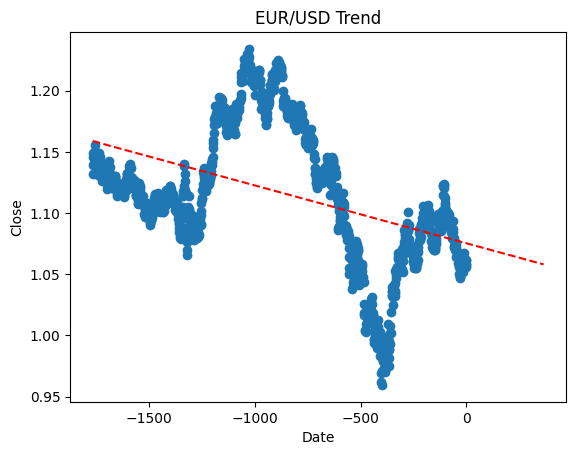

In [63]:
# Import libraries
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load data
df = pd.read_csv("EURUSD_.csv", index_col="Date", parse_dates=True)

# Convert index to a numeric format representing days
df.reset_index(inplace=True)  # Reset index to move Date from index to column
df['Date'] = pd.to_datetime(df['Date'], utc=True)  # Convert to datetime with utc=True
df['Date'] = (df['Date'] - pd.Timestamp("2023-11-03", tz='UTC')) / pd.Timedelta('1D')  # Convert to days since epoch

# Calculate trend using linear regression
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df['Date'], df['Close'])

# Print slope and intercept
print("The slope of the trend is:", slope)
print("The intercept of the trend is:", intercept)

# Create a new array of x-values that includes the future date
future_date = pd.to_datetime("2024-01-01", utc=True) # Example future date
future_days = (future_date - pd.Timestamp("2023-01-01", tz='UTC')) / pd.Timedelta('1D') # Convert to days since epoch
x = np.append(df['Date'], future_days) # Append to the existing x-values

# Calculate the corresponding y-values using the slope and intercept
y = slope * x + intercept

# Plot the data and the trend line
plt.scatter(df['Date'], df['Close']) # Plot the original data
plt.plot(x, y, 'r--') # Plot the trend line
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('EUR/USD Trend')
plt.show()


In [64]:
df.tail()

Date      Open      High       Low     Close  Volume  Dividends  \
1258  -4.0  1.056245  1.062600  1.054841  1.056245       0        0.0   
1259  -3.0  1.061504  1.066906  1.056759  1.061504       0        0.0   
1260  -2.0  1.057910  1.058078  1.052288  1.057910       0        0.0   
1261  -1.0  1.058705  1.067008  1.058425  1.058705       0        0.0   
1262   0.0  1.061909  1.073700  1.061549  1.061909       0        0.0   

      Stock Splits  
1258           0.0  
1259           0.0  
1260           0.0  
1261           0.0  
1262           0.0

# EMA scalping

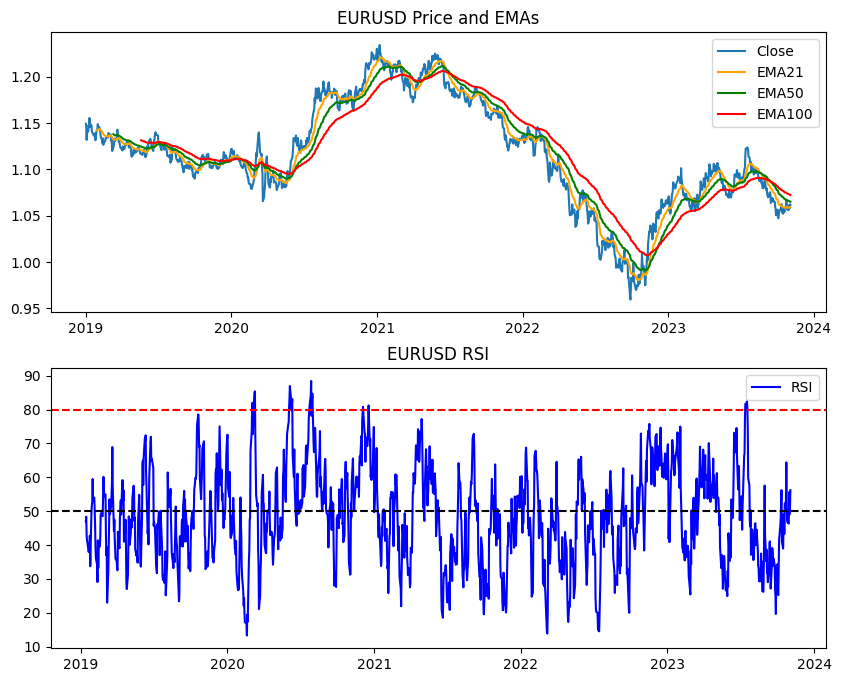

C:\Users\nuruj\AppData\Local\Temp\ipykernel_14176\3608559963.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df["Close"][i] > df["EMA21"][i] and df["EMA50"][i] > df["EMA100"][i] and df["EMA50"][i-1] <= df["EMA100"][i-1]:
C:\Users\nuruj\AppData\Local\Temp\ipykernel_14176\3608559963.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif df["Close"][i] < df["EMA21"][i] and df["EMA50"][i] < df["EMA100"][i] and df["EMA50"][i-1] >= df["EMA100"][i-1]:
C:\Users\nuruj\AppData\Local\Temp\ipykernel_14176\3608559963.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version,

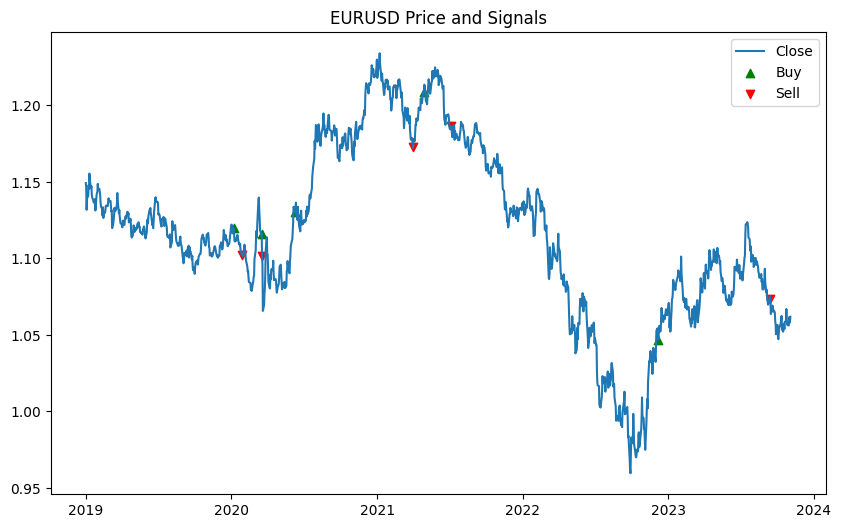

In [56]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib

# Load data
df = pd.read_csv("EURUSD_.csv", index_col="Date", parse_dates=True)

# Calculate three EMAs
df["EMA21"] = talib.EMA(df["Close"], timeperiod=21)
df["EMA50"] = talib.EMA(df["Close"], timeperiod=50)
df["EMA100"] = talib.EMA(df["Close"], timeperiod=100)

# Calculate RSI
df["RSI"] = talib.RSI(df["Close"], timeperiod=9)

# Plot price, EMAs, and RSI
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.plot(df["Close"], label="Close")
plt.plot(df["EMA21"], label="EMA21", color="orange")
plt.plot(df["EMA50"], label="EMA50", color="green")
plt.plot(df["EMA100"], label="EMA100", color="red")
plt.legend()
plt.title("EURUSD Price and EMAs")
plt.subplot(2,1,2)
plt.plot(df["RSI"], label="RSI", color="blue")
plt.axhline(50, color="black", linestyle="--")
plt.axhline(80, color="red", linestyle="--")
plt.legend()
plt.title("EURUSD RSI")
plt.show()

# Define signal function
def signal(df):
    # Initialize signal column
    df["Signal"] = 0
    # Loop through the data
    for i in range(1, len(df)):
        # Check if the price closes above the 21-period EMA and the 50-period EMA crosses above the 100-period EMA
        if df["Close"][i] > df["EMA21"][i] and df["EMA50"][i] > df["EMA100"][i] and df["EMA50"][i-1] <= df["EMA100"][i-1]:
            # Check if the RSI is above 50 and not above 80
            if df["RSI"][i] > 50 and df["RSI"][i] < 80:
                # Generate a buy signal
                df["Signal"][i] = 1
        # Check if the price closes below the 21-period EMA and the 50-period EMA crosses below the 100-period EMA
        elif df["Close"][i] < df["EMA21"][i] and df["EMA50"][i] < df["EMA100"][i] and df["EMA50"][i-1] >= df["EMA100"][i-1]:
            # Check if the RSI is below 50 and not below 20
            if df["RSI"][i] < 50 and df["RSI"][i] > 20:
                # Generate a sell signal
                df["Signal"][i] = -1
    # Return the dataframe with signals
    return df

# Apply signal function
df = signal(df)

# Mark buy and sell signals on price chart
plt.figure(figsize=(10,6))
plt.plot(df["Close"], label="Close")
plt.scatter(df.index, df["Close"].where(df["Signal"] == 1), marker="^", color="green", label="Buy")
plt.scatter(df.index, df["Close"].where(df["Signal"] == -1), marker="v", color="red", label="Sell")
plt.title("EURUSD Price and Signals")
plt.legend()
plt.show()


In [57]:
df["Signal"].unique()

array([ 0,  1, -1], dtype=int64)

# Breakout

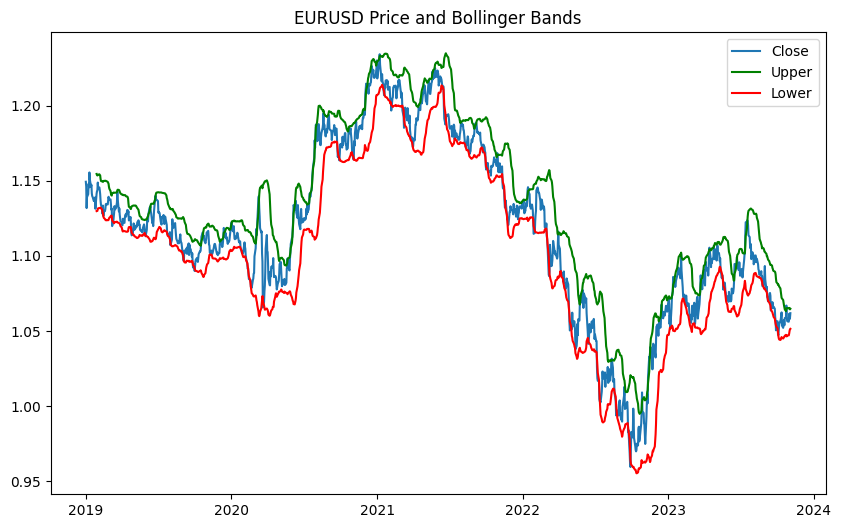

C:\Users\nuruj\AppData\Local\Temp\ipykernel_14176\1165743801.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df["Close"][i] > df[upper][i] and df["Close"][i-1] <= df[upper][i-1]:
C:\Users\nuruj\AppData\Local\Temp\ipykernel_14176\1165743801.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif df["Close"][i] < df[lower][i] and df["Close"][i-1] >= df[lower][i-1]:
C:\Users\nuruj\AppData\Local\Temp\ipykernel_14176\1165743801.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

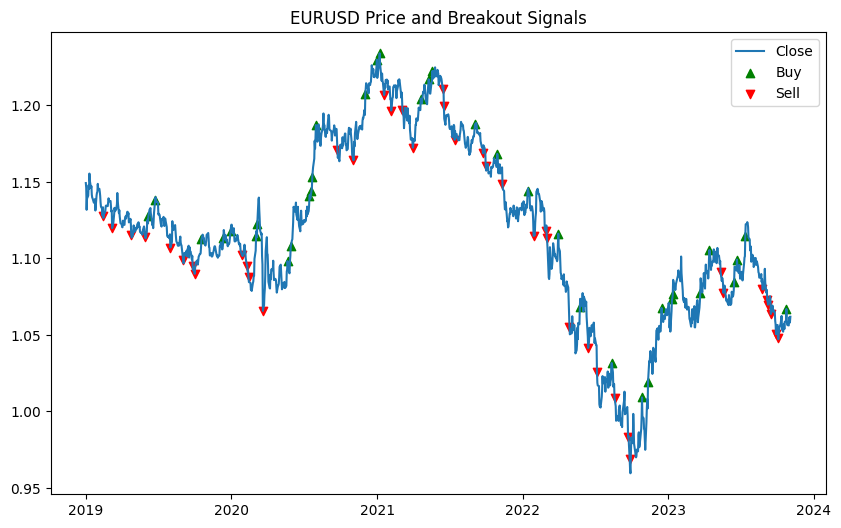

In [53]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib

# Load data
df = pd.read_csv("EURUSD_.csv", index_col="Date", parse_dates=True)

# Calculate Bollinger Bands
df["Upper"], df["Middle"], df["Lower"] = talib.BBANDS(df["Close"], timeperiod=20, nbdevup=2, nbdevdn=2)

# Plot price and Bollinger Bands
plt.figure(figsize=(10,6))
plt.plot(df["Close"], label="Close")
plt.plot(df["Upper"], label="Upper", color="green")
plt.plot(df["Lower"], label="Lower", color="red")
plt.legend()
plt.title("EURUSD Price and Bollinger Bands")
plt.show()

# Define breakout function
def breakout(df, upper, lower):
    # Initialize signal column
    df["Signal"] = 0
    # Loop through the data
    for i in range(1, len(df)):
        # Check if the price closes above the upper band
        if df["Close"][i] > df[upper][i] and df["Close"][i-1] <= df[upper][i-1]:
            # Generate a buy signal
            df["Signal"][i] = 1
        # Check if the price closes below the lower band
        elif df["Close"][i] < df[lower][i] and df["Close"][i-1] >= df[lower][i-1]:
            # Generate a sell signal
            df["Signal"][i] = -1
    # Return the dataframe with signals
    return df

# Apply breakout function
df = breakout(df, "Upper", "Lower")

# Mark buy and sell signals on price chart
plt.figure(figsize=(10,6))
plt.plot(df["Close"], label="Close")
plt.scatter(df.index, df["Close"].where(df["Signal"] == 1), marker="^", color="green", label="Buy")
plt.scatter(df.index, df["Close"].where(df["Signal"] == -1), marker="v", color="red", label="Sell")
plt.title("EURUSD Price and Breakout Signals")
plt.legend()
plt.show()


In [48]:
data.to_csv("EURUSD_.csv")

In [54]:
breakout(df, "Upper", "Lower")

C:\Users\nuruj\AppData\Local\Temp\ipykernel_14176\1165743801.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df["Close"][i] > df[upper][i] and df["Close"][i-1] <= df[upper][i-1]:
C:\Users\nuruj\AppData\Local\Temp\ipykernel_14176\1165743801.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif df["Close"][i] < df[lower][i] and df["Close"][i-1] >= df[lower][i-1]:
C:\Users\nuruj\AppData\Local\Temp\ipykernel_14176\1165743801.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

Open      High       Low     Close  Volume  \
Date                                                                        
2019-01-01 00:00:00+00:00  1.149425  1.155001  1.146500  1.149306       0   
2019-01-02 00:00:00+00:00  1.146132  1.149700  1.134572  1.146171       0   
2019-01-03 00:00:00+00:00  1.131734  1.140914  1.131734  1.131811       0   
2019-01-04 00:00:00+00:00  1.139095  1.141774  1.134816  1.139108       0   
2019-01-07 00:00:00+00:00  1.141292  1.147447  1.140524  1.141044       0   
...                             ...       ...       ...       ...     ...   
2023-10-30 00:00:00+00:00  1.056245  1.062600  1.054841  1.056245       0   
2023-10-31 00:00:00+00:00  1.061504  1.066906  1.056759  1.061504       0   
2023-11-01 00:00:00+00:00  1.057910  1.058078  1.052288  1.057910       0   
2023-11-02 00:00:00+00:00  1.058705  1.067008  1.058425  1.058705       0   
2023-11-03 00:00:00+00:00  1.061909  1.073700  1.061549  1.061909       0   

                           Dividends  Stock Splits     Upper    Middle  \
Date                                                                     
2019-01-01 00:00:00+00:00        0.0           0.0       NaN       NaN   
2019-01-02 00:00:00+00:00        0.0           0.0       NaN       NaN   
2019-01-03 00:00:00+00:00        0.0           0.0       NaN       NaN   
2019-01-04 00:00:00+00:00        0.0           0.0       NaN       NaN   
2019-01-07 00:00:00+00:00        0.0           0.0       NaN       NaN   
...                              ...           ...       ...       ...   
2023-10-30 00:00:00+00:00        0.0           0.0  1.065277  1.056211   
2023-10-31 00:00:00+00:00        0.0           0.0  1.065412  1.056882   
2023-11-01 00:00:00+00:00        0.0           0.0  1.064709  1.057416   
2023-11-02 00:00:00+00:00        0.0           0.0  1.064440  1.057816   
2023-11-03 00:00:00+00:00        0.0           0.0  1.064865  1.058179   

                              Lower  Signal  
Date                                         
2019-01-01 00:00:00+00:00       NaN       0  
2019-01-02 00:00:00+00:00       NaN       0  
2019-01-03 00:00:00+00:00       NaN       0  
2019-01-04 00:00:00+00:00       NaN       0  
2019-01-07 00:00:00+00:00       NaN       0  
...                             ...     ...  
2023-10-30 00:00:00+00:00  1.047145       0  
2023-10-31 00:00:00+00:00  1.048353       0  
2023-11-01 00:00:00+00:00  1.050124       0  
2023-11-02 00:00:00+00:00  1.051193       0  
2023-11-03 00:00:00+00:00  1.051492       0  

[1263 rows x 11 columns]

In [55]:
df['Signal'].unique()

array([ 0, -1,  1], dtype=int64)

# AO

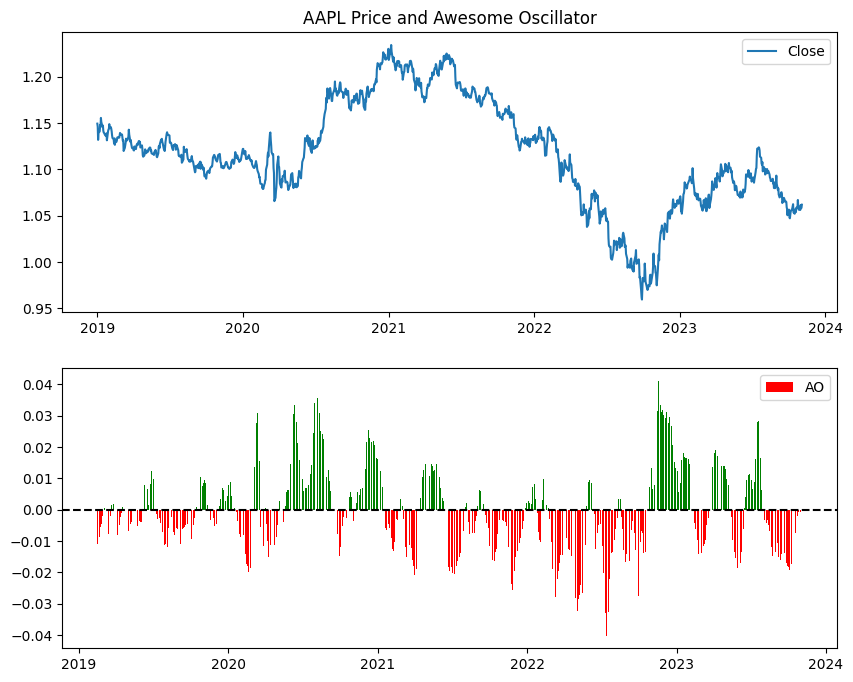

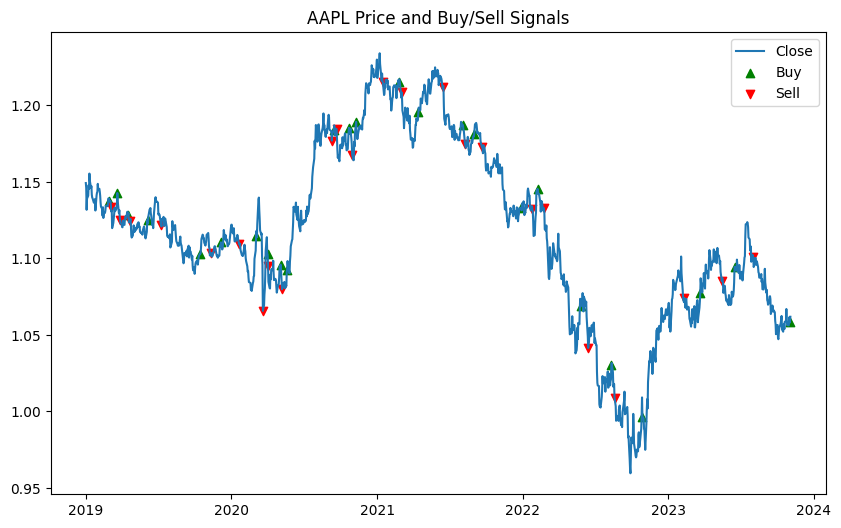

In [41]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta

# Load data
df = pd.read_csv("EURUSD_.csv", index_col="Date", parse_dates=True)

# Calculate awesome oscillator
df["AO"] = ta.ao(df["High"], df["Low"])

# Plot price and awesome oscillator
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.plot(df["Close"], label="Close")
plt.title("AAPL Price and Awesome Oscillator")
plt.legend()
plt.subplot(2,1,2)
plt.bar(df.index, df["AO"], color=df["AO"].apply(lambda x: "green" if x > 0 else "red"), label="AO")
plt.axhline(0, color="black", linestyle="--")
plt.legend()
plt.show()

# Define buy and sell signals
df["Buy"] = np.where((df["AO"] > 0) & (df["AO"].shift(1) < 0), 1, 0)
df["Sell"] = np.where((df["AO"] < 0) & (df["AO"].shift(1) > 0), -1, 0)

# Mark buy and sell signals on price chart
plt.figure(figsize=(10,6))
plt.plot(df["Close"], label="Close")
plt.scatter(df.index, df["Close"].where(df["Buy"] == 1), marker="^", color="green", label="Buy")
plt.scatter(df.index, df["Close"].where(df["Sell"] == -1), marker="v", color="red", label="Sell")
plt.title("AAPL Price and Buy/Sell Signals")
plt.legend()
plt.show()


In [42]:
df['Buy'].unique()

array([0, 1])

In [18]:
from tradingview_ta import TA_Handler, Interval, Exchange

eurusd = TA_Handler(
    symbol="EURUSD",
    screener="forex",
    exchange="FX_IDC",
    interval=Interval.INTERVAL_1_HOUR,
    # proxies={'http': 'http://example.com:8080'} # Uncomment to enable proxy (replace the URL).
)
print(eurusd.get_analysis().summary)


{'RECOMMENDATION': 'BUY', 'BUY': 15, 'SELL': 1, 'NEUTRAL': 10}


In [20]:
from tradingview_ta import TA_Handler, Interval, Exchange

eurusd = TA_Handler(
    symbol="EURUSD",
    screener="forex",
    exchange="FX_IDC",
    interval=Interval.INTERVAL_1_DAY,
    # proxies={'http': 'http://example.com:8080'} # Uncomment to enable proxy (replace the URL).
)
print(eurusd.get_analysis().summary)


{'RECOMMENDATION': 'BUY', 'BUY': 12, 'SELL': 3, 'NEUTRAL': 10}


In [19]:
from tradingview_ta import TA_Handler, Interval, Exchange

tesla = TA_Handler(
    symbol="AAPL",
    screener="america",
    exchange="NASDAQ",
    interval=Interval.INTERVAL_1_DAY,
    # proxies={'http': 'http://example.com:8080'} # Uncomment to enable proxy (replace the URL).
)
print(tesla.get_analysis().summary)


{'RECOMMENDATION': 'BUY', 'BUY': 14, 'SELL': 4, 'NEUTRAL': 8}


In [15]:
df

Open    High     Low   Close      Volume  High20  Low20
Date                                                                 
2021-03-12  275.00  295.50  262.27  264.50  25,845,900     NaN    NaN
2021-03-11  241.64  281.50  232.60  260.00  28,312,490     NaN    NaN
2021-03-10  269.43  348.50  172.00  265.00  71,570,570     NaN    NaN
2021-03-09  217.71  249.85  208.51  246.90  39,099,328     NaN    NaN
2021-03-08  154.89  210.87  146.10  194.50  63,565,621     NaN    NaN
...            ...     ...     ...     ...         ...     ...    ...
2020-03-20    4.08    4.08    3.65    3.76   7,722,194    6.47   2.57
2020-03-19    3.71    4.20    3.55    4.19   5,039,539    6.47   2.57
2020-03-18    4.10    4.25    3.50    3.77   3,651,709    6.47   2.57
2020-03-17    4.40    4.65    4.11    4.23   3,562,210    6.47   2.57
2020-03-16    3.93    4.57    3.90    4.37   4,866,696    5.09   2.57

[251 rows x 7 columns]

In [14]:
df.dtypes

Open      float64
High      float64
Low       float64
Close     float64
Volume     object
High20    float64
Low20     float64
dtype: object

## Getting Price

In [1]:
import MetaTrader5 as mt5
# initialize the MetaTrader 5 terminal
mt5.initialize(login = 79144406, server = "Exness-MT5Trial8", password="*Jaman@1310#")
# get the current price of EURUSD
eurusd_tick = mt5.symbol_info_tick("EURUSD")
# print the bid and ask prices
print("Bid - Sell: ", eurusd_tick.bid)
print("Ask - Buy: ", eurusd_tick.ask)
# shut down the MetaTrader 5 terminal
#mt5.shutdown()
print(eurusd_tick.bid - eurusd_tick.ask)


Bid - Sell:  1.07132
Ask - Buy:  1.07132
0.0


## Fibonacci retracements/extensions 

             time     open     high      low    close  tick_volume  spread  \
0      1601510400  1.17236  1.17697  1.17173  1.17441        55701      50   
1      1601596800  1.17439  1.17446  1.16959  1.17153        59156      50   
2      1601769600  1.17120  1.17201  1.17062  1.17197         1905      50   
3      1601856000  1.17198  1.17975  1.17179  1.17892        35595      50   
4      1601942400  1.17891  1.18078  1.17293  1.17372        48210      50   
...           ...      ...      ...      ...      ...          ...     ...   
16567  1698350400  1.05566  1.05639  1.05552  1.05612          785       0   
16568  1698354000  1.05617  1.05617  1.05562  1.05604          323      15   
16569  1698357600  1.05604  1.05643  1.05604  1.05637          243      15   
16570  1698361200  1.05637  1.05656  1.05623  1.05640          524       0   
16571  1698364800  1.05640  1.05646  1.05561  1.05580         1202       0   

       real_volume  
0                0  
1                0  


C:\Users\nuruj\AppData\Local\Temp\ipykernel_3404\1366807706.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  close = df["close"][-1]


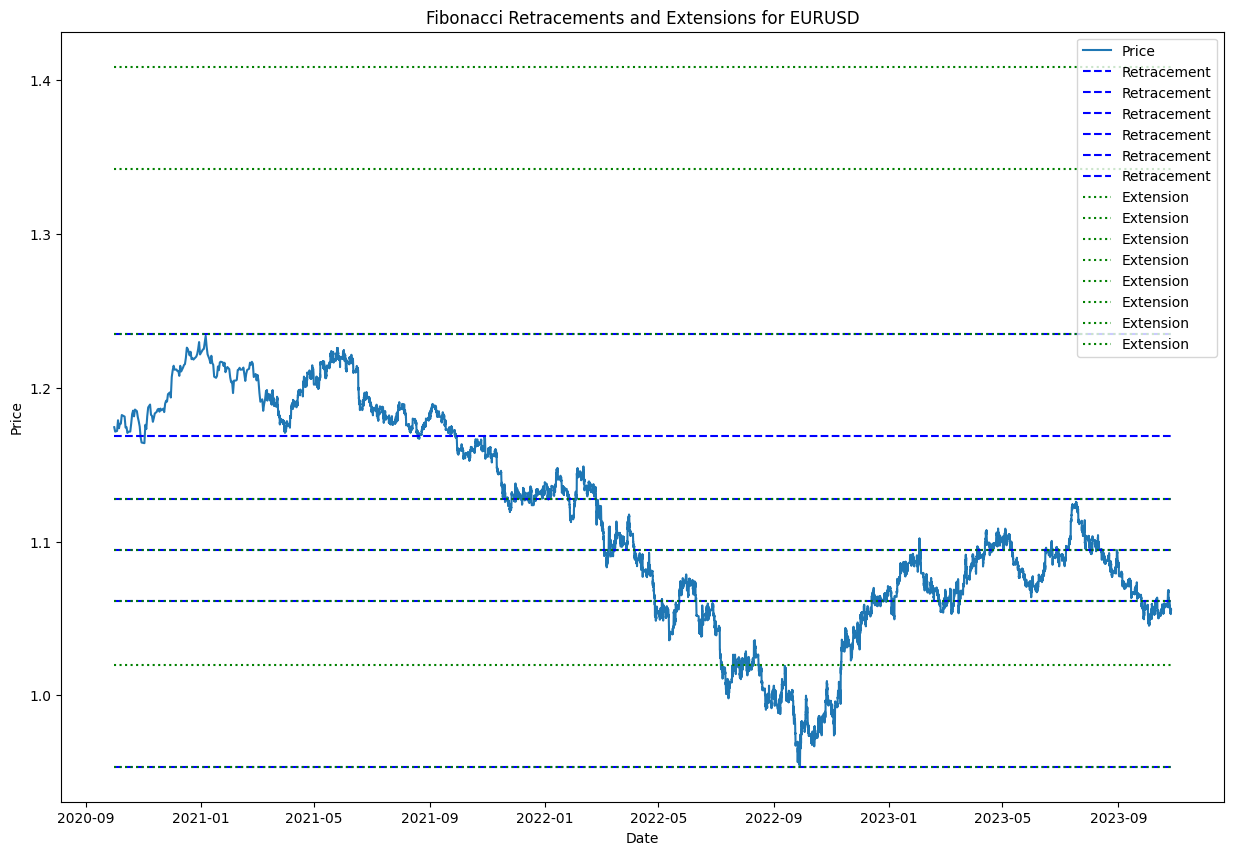


The output of this code is shown in this image. You can see how the Fibonacci levels act as potential support 
and resistance levels for the price movements of EUR/USD. You can use these levels 
to identify possible entry and exit points for your trades, as well as to set your stop loss and profit target levels.


In [11]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# initialize the MetaTrader 5 terminal
mt5.initialize()

# get the historical data of EUR/USD from 2020-01-01 to 2020-12-31
symbol = "EURUSD"
timeframe = mt5.TIMEFRAME_H1
start_date = "2020-10-01"
end_date = "2023-10-27"
rates = mt5.copy_rates_range(symbol, timeframe, pd.to_datetime(start_date), pd.to_datetime(end_date))

# create a DataFrame from the rates
df = pd.DataFrame(rates)
print(df)
df["time"] = pd.to_datetime(df["time"], unit="s")
df.set_index("time", inplace=True)

# calculate the high, low, and close prices of the period
high = df["high"].max()
low = df["low"].min()
close = df["close"][-1]

# calculate the Fibonacci retracement levels
retracement_levels = [high, high - 0.236 * (high - low), high - 0.382 * (high - low), high - 0.5 * (high - low), high - 0.618 * (high - low), low]
print(retracement_levels )
# calculate the Fibonacci extension levels
extension_levels = [low, low + 0.236 * (high - low), low + 0.382 * (high - low), low + 0.5 * (high - low), low + 0.618 * (high - low), high, high + 0.382 * (high - low), high + 0.618 * (high - low)]

# plot the price chart and the Fibonacci levels
plt.figure(figsize=(15,10))
plt.plot(df.index, df["close"], label="Price")
for level in retracement_levels:
    plt.hlines(level, xmin=df.index[0], xmax=df.index[-1], colors="blue", linestyles="dashed", label="Retracement")
for level in extension_levels:
    plt.hlines(level, xmin=df.index[0], xmax=df.index[-1], colors="green", linestyles="dotted", label="Extension")
plt.title(f"Fibonacci Retracements and Extensions for {symbol}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()
print('''
The output of this code is shown in this image. You can see how the Fibonacci levels act as potential support 
and resistance levels for the price movements of EUR/USD. You can use these levels 
to identify possible entry and exit points for your trades, as well as to set your stop loss and profit target levels.''')

# shut down the MetaTrader 5 terminal


## Forecasting

#### Facebook Prohet

                       ds        y
0     2020-10-01 00:00:00  1.17441
1     2020-10-02 00:00:00  1.17153
2     2020-10-04 00:00:00  1.17197
3     2020-10-05 00:00:00  1.17892
4     2020-10-06 00:00:00  1.17372
...                   ...      ...
16567 2023-10-26 20:00:00  1.05612
16568 2023-10-26 21:00:00  1.05604
16569 2023-10-26 22:00:00  1.05637
16570 2023-10-26 23:00:00  1.05640
16571 2023-10-27 00:00:00  1.05580

[16572 rows x 2 columns]


01:33:49 - cmdstanpy - INFO - Chain [1] start processing
01:34:07 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\nuruj\anaconda3\envs\trader\lib\site-packages\prophet\plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\nuruj\anaconda3\envs\trader\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
C:\Users\nuruj\anaconda3\envs\trader\lib\site-packages\prophet\plot.py:226: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is dep

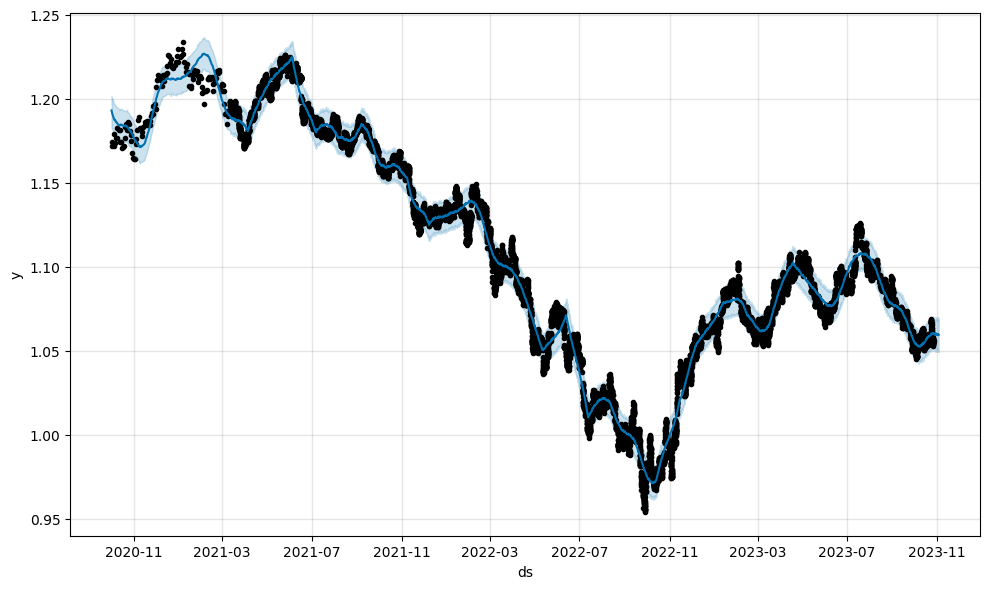

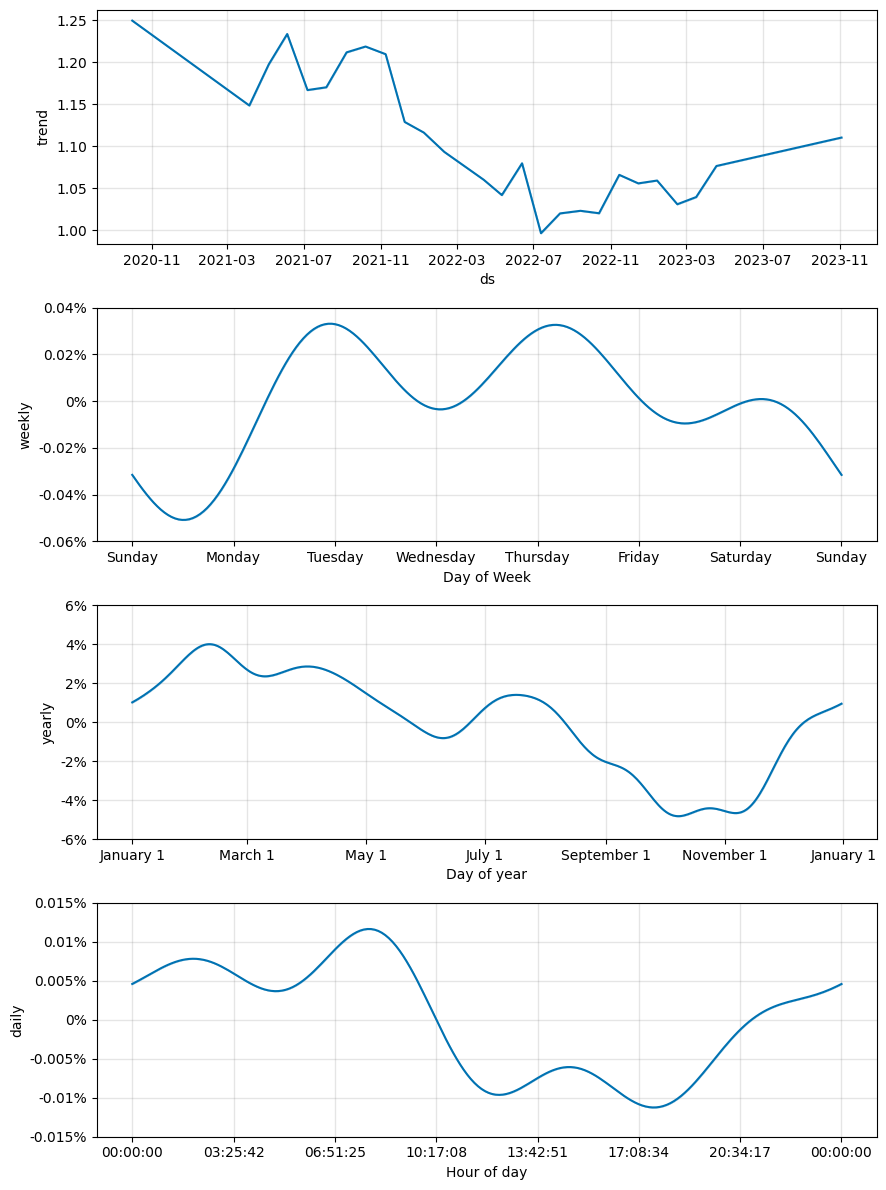

In [12]:
import pandas as pd
from prophet import Prophet

# create a DataFrame from the rates
df = pd.DataFrame(rates)
df["time"] = pd.to_datetime(df["time"], unit="s")
df.set_index("time", inplace=True)

# rename the columns to ds and y
df = df[["close"]].reset_index().rename(columns={"time": "ds", "close": "y"})
print(df)
# create a Prophet object
model = Prophet(seasonality_mode="multiplicative", changepoint_prior_scale=0.05)

# fit the model to the data
model.fit(df)
# create a future DataFrame with 7 days of hourly data
future = model.make_future_dataframe(periods=7*24, freq="H")

# generate predictions for the future DataFrame
forecast = model.predict(future)

# plot the predictions and their components
model.plot(forecast)
model.plot_components(forecast)
plt.show()


C:\Users\nuruj\anaconda3\envs\trader\lib\site-packages\prophet\plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\nuruj\anaconda3\envs\trader\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
C:\Users\nuruj\anaconda3\envs\trader\lib\site-packages\prophet\plot.py:226: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. 

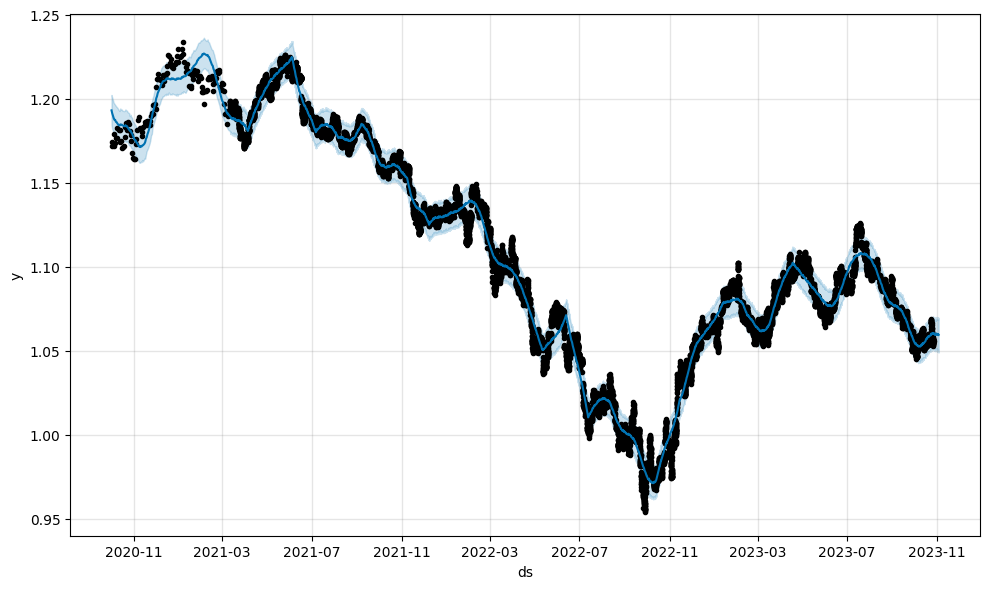

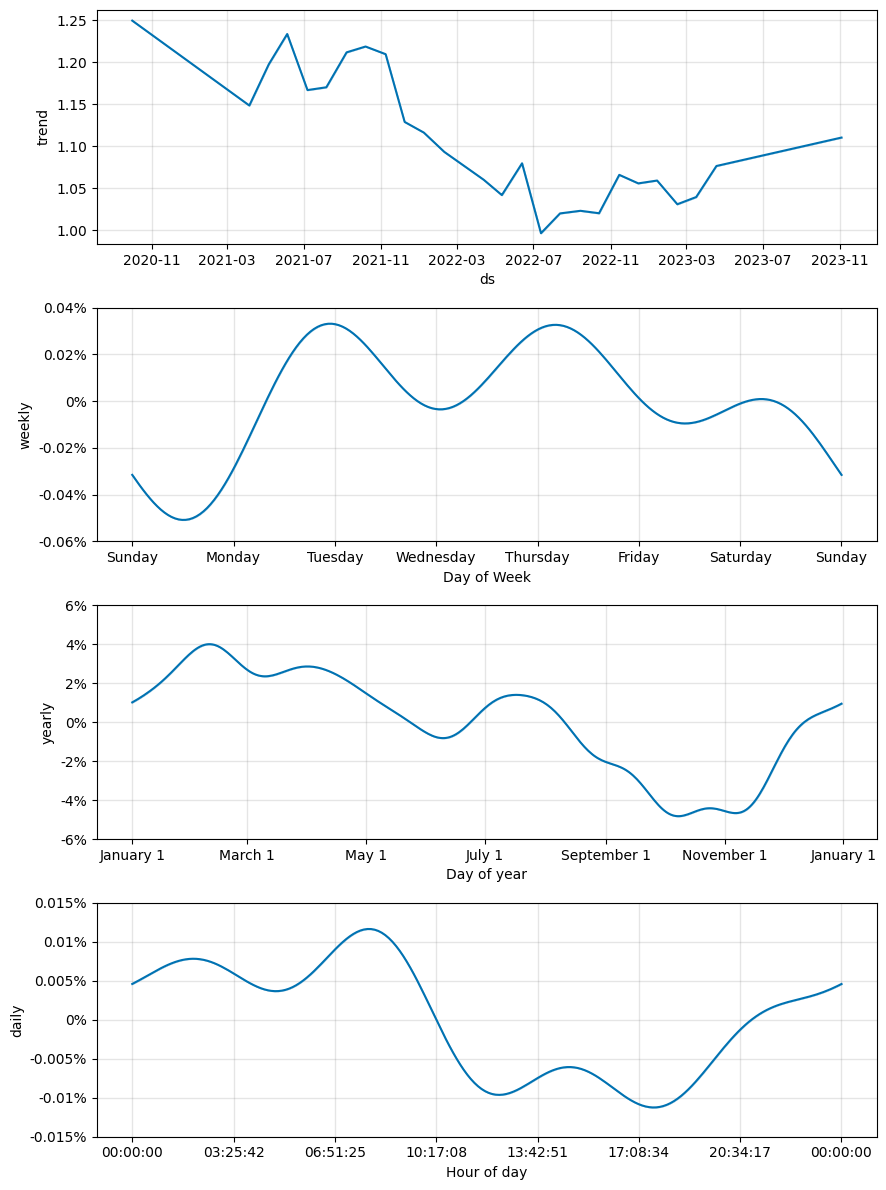

In [4]:
# create a future DataFrame with 7 days of hourly data
future = model.make_future_dataframe(periods=7*24, freq="H")

# generate predictions for the future DataFrame
forecast = model.predict(future)

# plot the predictions and their components
model.plot(forecast)
model.plot_components(forecast)
plt.show()


#### ARIMA

C:\Users\nuruj\anaconda3\envs\trader\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


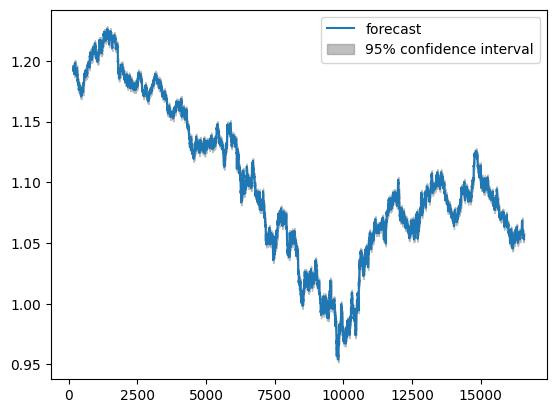

In [5]:
import statsmodels.api as sm

# create an ARIMA(2, 0, 0) model
model = sm.tsa.ARIMA(df["y"], order=(2, 0, 0))

# fit the model to the data
fit = model.fit()

# forecast the next 7 days of data
forecast = fit.forecast(7*24)
from statsmodels.graphics.tsaplots import plot_predict

# plot the forecasts and their intervals
plot_predict(fit, 7*24)
plt.show()


# plot the forecasts and their intervals
#fit.plot(forecast)
#plt.show()


In [ ]:
df['y']

#### Exponential Smoothing

Exponential Smoothing (SES): This method uses a weighted average of past observations, where the weights decay 
exponentially as the observations get older. The level of decay is controlled by a smoothing parameter alpha, which 
ranges from 0 to 1. A higher alpha gives more weight to recent observations, while a lower alpha 
gives more weight to distant observations. This method is suitable for data with no trend or seasonality
300    1.193051
301    1.193111
302    1.192829
303    1.193777
304    1.194252
         ...   
563    1.211578
564    1.211698
565    1.210975
566    1.210846
567    1.210906
Length: 268, dtype: float64
300    1.193051
301    1.193111
302    1.192829
303    1.193777
304    1.194252
305    1.194371
306    1.193648
307    1.193520
308    1.193579
309    1.193297
310    1.194245
311    1.194720
312    1.194839
313    1.194117
314    1.193988
315    1.194048
316    1.193766
317    1.194713
318    1.195188
319    1.195307
dtype: float64
0      1.174043
1      1.1741

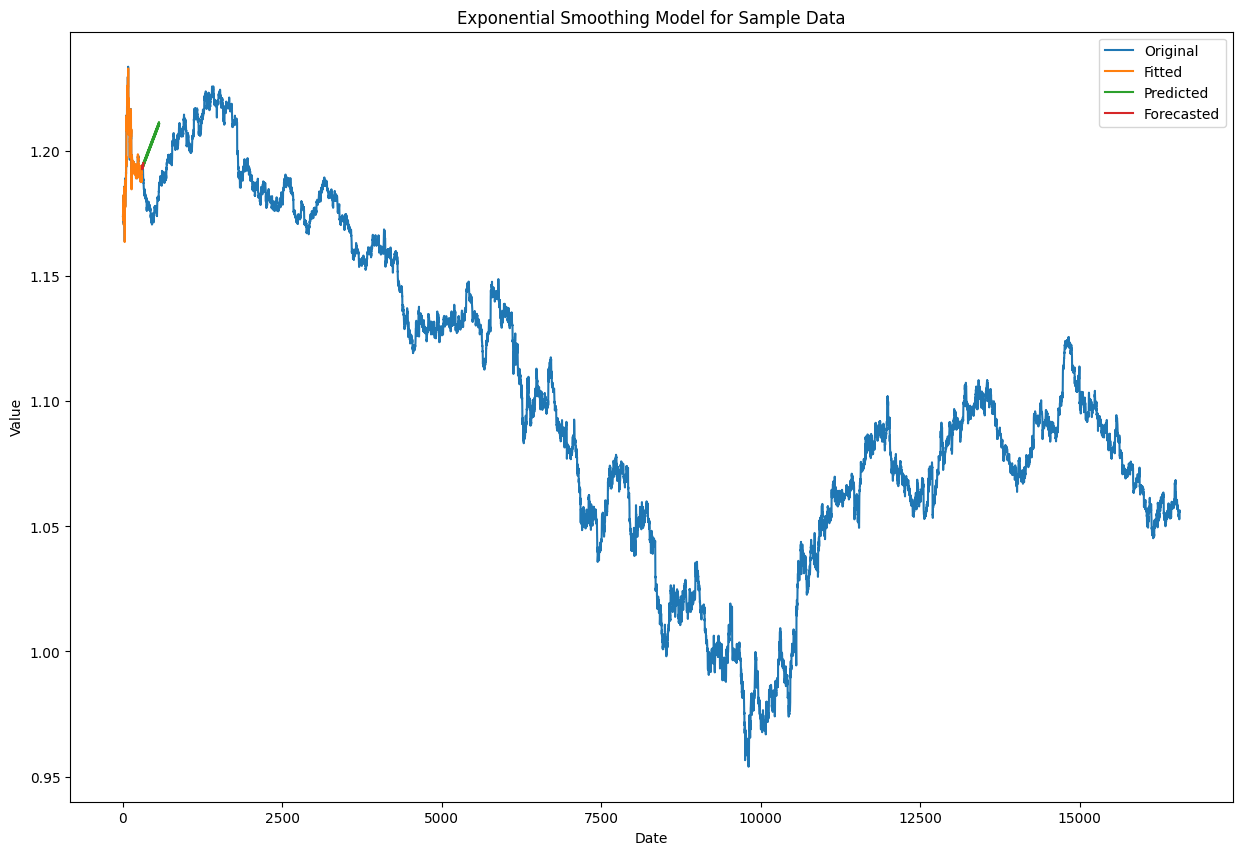

In [6]:
print('''Exponential Smoothing (SES): This method uses a weighted average of past observations, where the weights decay 
exponentially as the observations get older. The level of decay is controlled by a smoothing parameter alpha, which 
ranges from 0 to 1. A higher alpha gives more weight to recent observations, while a lower alpha 
gives more weight to distant observations. This method is suitable for data with no trend or seasonality''')
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np
import pandas as pd

# Generate some sample data
ts = df['y']

# Split into train and test sets
train = ts[:300]
test = ts[300:400]

# Fit an exponential smoothing model with additive trend and seasonality
model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=7)

result = model.fit()

# Predict the next 20 values using the predict method
pred = result.predict(start=test.index[0], end=test.index[-1]+(7*24))
print(pred)

# Forecast the next 20 values using the forecast method
fcast = result.forecast(steps=20)
print(fcast)

# Access the fitted values using the fittedvalues attribute
fitted = result.fittedvalues
print(fitted)

# Access the forecast values using the fcastvalues attribute
fcast_values = result.fcastvalues
print(fcast_values)
import matplotlib.pyplot as plt

# plot the original data, the fitted values, and the predicted and forecasted values
plt.figure(figsize=(15,10))
plt.plot(ts, label="Original")
plt.plot(fitted, label="Fitted")
plt.plot(pred, label="Predicted")
plt.plot(fcast, label="Forecasted")
plt.title("Exponential Smoothing Model for Sample Data")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()




300    1.193066
301    1.193114
302    1.192828
303    1.193780
304    1.194254
         ...   
563    1.210345
564    1.210454
565    1.209705
566    1.209591
567    1.209639
Length: 268, dtype: float64
300    1.193066
301    1.193114
302    1.192828
303    1.193780
304    1.194254
305    1.194364
306    1.193615
307    1.193501
308    1.193549
309    1.193263
310    1.194215
311    1.194689
312    1.194799
313    1.194050
314    1.193936
315    1.193984
316    1.193698
317    1.194650
318    1.195124
319    1.195234
Name: simulation, dtype: float64
0      1.174410
1      1.174124
2      1.172482
3      1.172444
4      1.179029
         ...   
295    1.190774
296    1.193732
297    1.192784
298    1.191789
299    1.191411
Length: 300, dtype: float64
300    1.193066
301    1.193114
302    1.192828
303    1.193780
304    1.194254
305    1.194364
306    1.193615
307    1.193501
308    1.193549
309    1.193263
310    1.194215
311    1.194689
312    1.194799
313    1.194050
314    1.193936

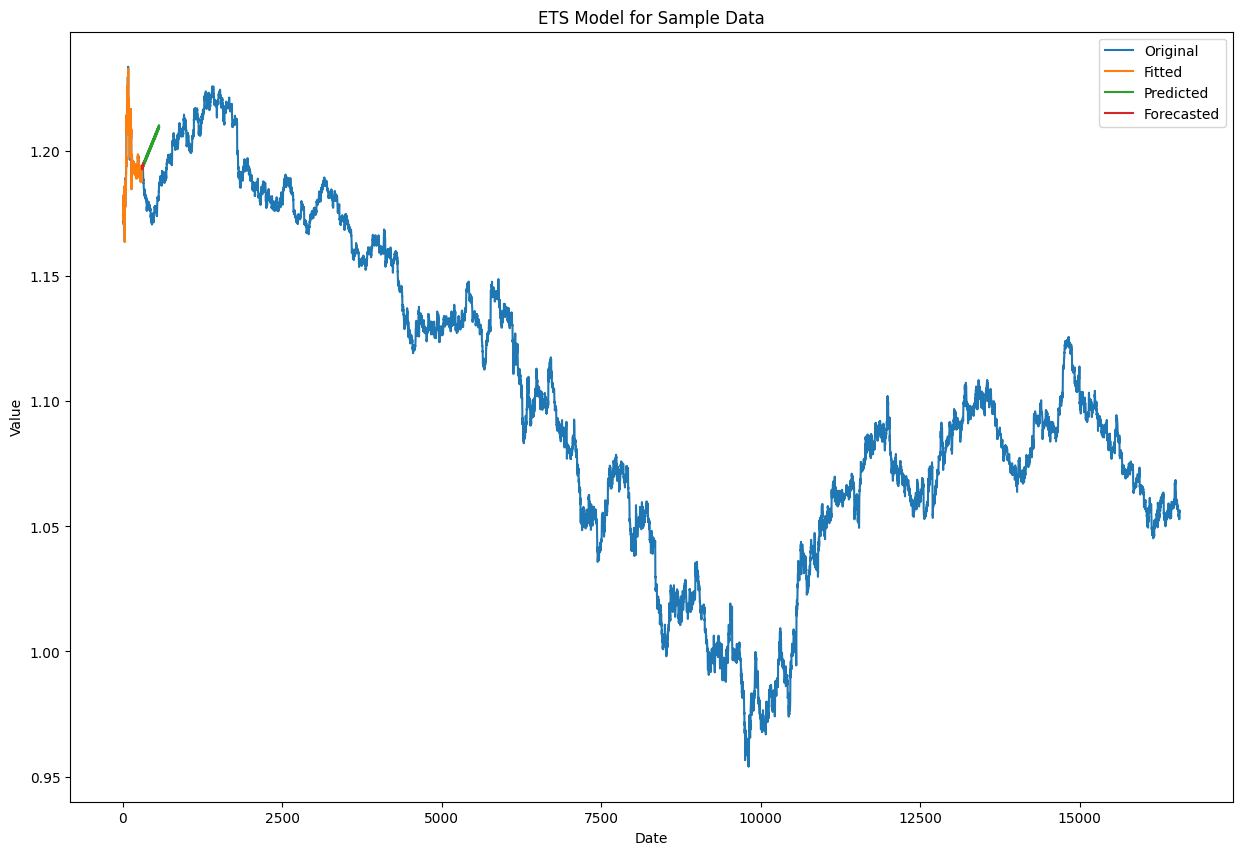

In [7]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

# create an ETSModel object
#model = ETSModel(train, error=None, trend=None, seasonal=None, seasonal_periods=7)
# create an ETSModel object with automatic parameter selection
model = ETSModel(train, error="add", trend="add", seasonal="add", seasonal_periods=7)

# fit the model
fit = model.fit()

# predict the next 100 values using the predict method
pred = fit.predict(start=test.index[0], end=test.index[-1]+(7*24))
print(pred)

# forecast the next 20 values using the forecast method
fcast = fit.forecast(steps=20)
print(fcast)

# access the fitted values using the fittedvalues attribute
fitted = fit.fittedvalues
print(fitted)

fcast = fit.forecast(steps=20)
print(fcast)

# access the forecast values using the values attribute of the Pandas Series
fcast_values = fcast.values
print(fcast_values)

# access the forecast values using the fcastvalues attribute
#fcast_values = fit.fcastvalues
#print(fcast_values)

# plot the original data, the fitted values, and the predicted and forecasted values
plt.figure(figsize=(15,10))
plt.plot(ts, label="Original")
plt.plot(fitted, label="Fitted")
plt.plot(pred, label="Predicted")
plt.plot(fcast, label="Forecasted")
plt.title("ETS Model for Sample Data")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()


In [ ]:
df

#### Kalman Filter`

## Pivot points

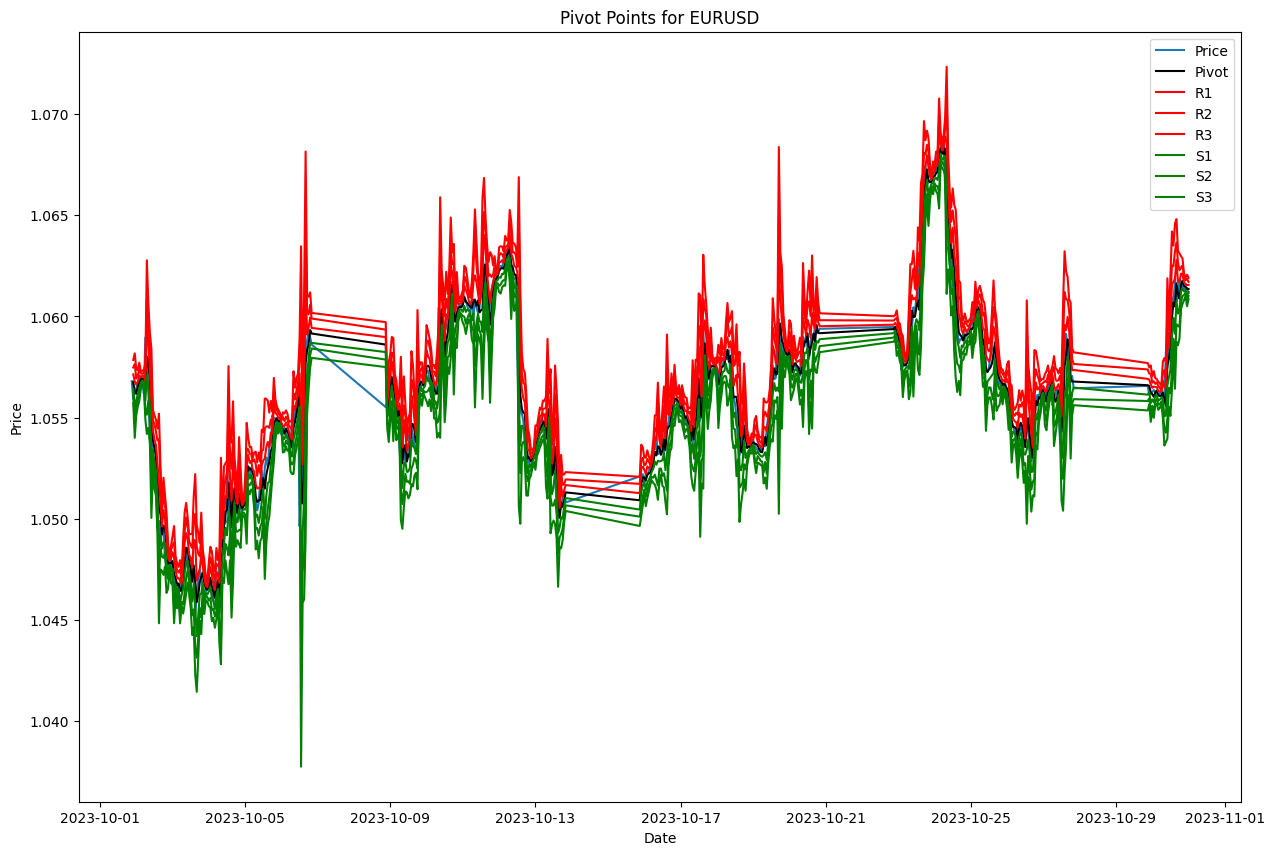


The output of this code is shown in this image. You can see how the pivot point and the support and resistance levels act as 
potential turning points for the price movements of EUR/USD. You can use these 
levels to identify possible entry and exit points for your trades, as well as to set your stop loss and profit target levels.



In [13]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# initialize the MetaTrader 5 terminal
mt5.initialize()

# get the historical data of EUR/USD from 2020-01-01 to 2020-12-31
symbol = "EURUSD"
timeframe = mt5.TIMEFRAME_H1
start_date = "2023-10-01"
end_date = "2023-10-31"
rates = mt5.copy_rates_range(symbol, timeframe, pd.to_datetime(start_date), pd.to_datetime(end_date))

# create a DataFrame from the rates
df = pd.DataFrame(rates)
df["time"] = pd.to_datetime(df["time"], unit="s")
df.set_index("time", inplace=True)

# calculate the high, low, and close prices of the previous period
high = df["high"].shift(1)
low = df["low"].shift(1)
close = df["close"].shift(1)

# calculate the pivot point and the support and resistance levels using the classic method
pivot = (high + low + close) / 3
r1 = (2 * pivot) - low
r2 = pivot + (high - low)
r3 = high + 2 * (pivot - low)
s1 = (2 * pivot) - high
s2 = pivot - (high - low)
s3 = low - 2 * (high - pivot)

# add the pivot point and the support and resistance levels to the DataFrame
df["pivot"] = pivot
df["r1"] = r1
df["r2"] = r2
df["r3"] = r3
df["s1"] = s1
df["s2"] = s2
df["s3"] = s3

# plot the price chart and the pivot point and the support and resistance levels
plt.figure(figsize=(15,10))
plt.plot(df.index, df["close"], label="Price")
plt.plot(df.index, df["pivot"], label="Pivot", color="black")
plt.plot(df.index, df["r1"], label="R1", color="red")
plt.plot(df.index, df["r2"], label="R2", color="red")
plt.plot(df.index, df["r3"], label="R3", color="red")
plt.plot(df.index, df["s1"], label="S1", color="green")
plt.plot(df.index, df["s2"], label="S2", color="green")
plt.plot(df.index, df["s3"], label="S3", color="green")
plt.title(f"Pivot Points for {symbol}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# shut down the MetaTrader 5 terminal
print('''
The output of this code is shown in this image. You can see how the pivot point and the support and resistance levels act as 
potential turning points for the price movements of EUR/USD. You can use these 
levels to identify possible entry and exit points for your trades, as well as to set your stop loss and profit target levels.
''')


##  Awesome Oscillator (AO)

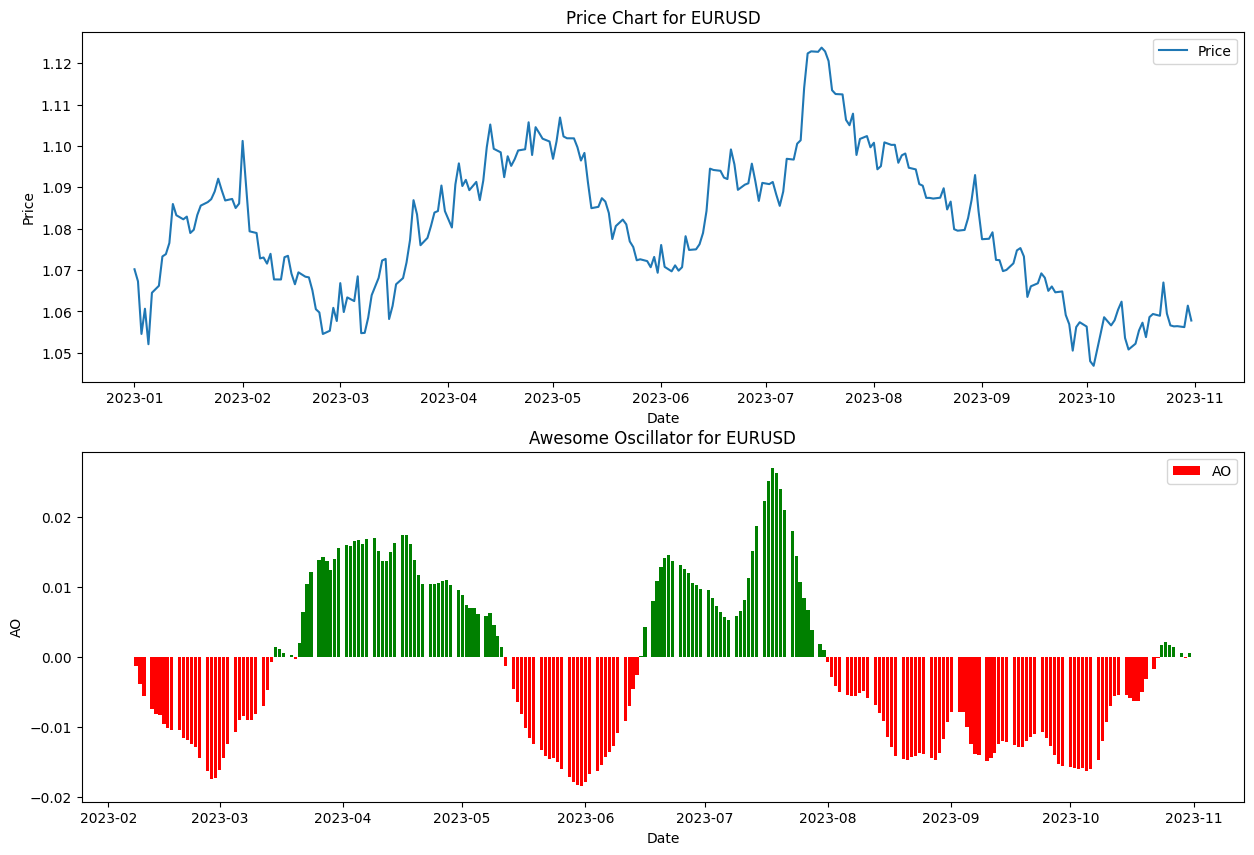

The output of this code is shown in this image. You can see how the Awesome Oscillator measures the momentum of the 
market by comparing the 5-period and 34-period simple moving averages of the median price. You can use this indicator to 
identify the strength and direction of the trend, as well as possible divergence and reversal signals. 
For example, you can look for bullish or bearish saucer patterns, zero line crossovers, or twin peaks formations. 
[https://top-trading-indicators.com/base/awesome-oscillator-indicator-mt5/] 


In [14]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# initialize the MetaTrader 5 terminal
mt5.initialize()

# get the historical data of EUR/USD from 2020-01-01 to 2020-12-31
symbol = "EURUSD"
timeframe = mt5.TIMEFRAME_D1
start_date = "2023-01-01"
end_date = "2023-10-31"
rates = mt5.copy_rates_range(symbol, timeframe, pd.to_datetime(start_date), pd.to_datetime(end_date))

# create a DataFrame from the rates
df = pd.DataFrame(rates)
df["time"] = pd.to_datetime(df["time"], unit="s")
df.set_index("time", inplace=True)

# calculate the median price of each period
df["median"] = (df["high"] + df["low"]) / 2

# calculate the 5-period and 34-period simple moving averages of the median price
df["sma5"] = df["median"].rolling(5).mean()
df["sma34"] = df["median"].rolling(34).mean()

# calculate the Awesome Oscillator as the difference between the two moving averages
df["ao"] = df["sma5"] - df["sma34"]

# plot the price chart and the Awesome Oscillator
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(df.index, df["close"], label="Price")
plt.title(f"Price Chart for {symbol}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.subplot(2,1,2)
plt.bar(df.index, df["ao"], label="AO", color=np.where(df["ao"] >= 0, "green", "red"))
plt.title(f"Awesome Oscillator for {symbol}")
plt.xlabel("Date")
plt.ylabel("AO")
plt.legend()
plt.show()

# shut down the MetaTrader 5 terminal
print('''The output of this code is shown in this image. You can see how the Awesome Oscillator measures the momentum of the 
market by comparing the 5-period and 34-period simple moving averages of the median price. You can use this indicator to 
identify the strength and direction of the trend, as well as possible divergence and reversal signals. 
For example, you can look for bullish or bearish saucer patterns, zero line crossovers, or twin peaks formations. 
[https://top-trading-indicators.com/base/awesome-oscillator-indicator-mt5/] ''')


## Relative Strength Index (RSI)

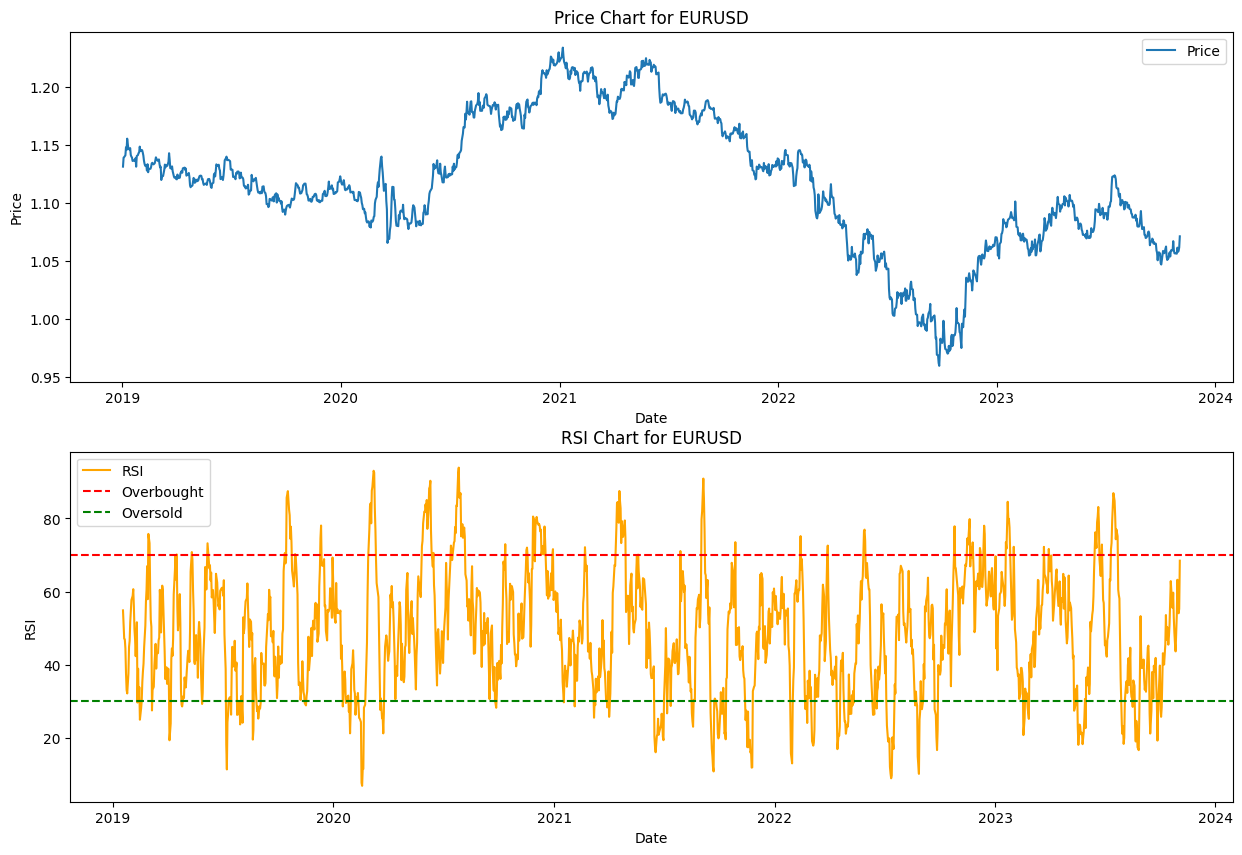

 The output of this code is shown in this image. You can see how the RSI measures the speed and change of price 
movements by comparing the recent gains and losses of a currency pair. You can use this indicator to identify overbought 
and oversold conditions, as well as trend confirmation and divergence signals. For example, you can look for RSI values above 
70 or below 30, RSI crossing above or below 50, or RSI forming higher highs or lower lows while the price does the opposite.
[https://github.com/mtamer/python-rsi]




In [2]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# initialize the MetaTrader 5 terminal
mt5.initialize()

# get the historical data of EUR/USD from 2020-01-01 to 2020-12-31
symbol = "EURUSD"
timeframe = mt5.TIMEFRAME_D1
start_date = "2019-01-01"
end_date = "2023-11-03"
rates = mt5.copy_rates_range(symbol, timeframe, pd.to_datetime(start_date), pd.to_datetime(end_date))

# create a DataFrame from the rates
df = pd.DataFrame(rates)
df["time"] = pd.to_datetime(df["time"], unit="s")
df.set_index("time", inplace=True)

# calculate the price change of each period
df["change"] = df["close"].diff()

# calculate the average gain and average loss over a 14-period window
df["gain"] = df["change"].clip(lower=0)
df["loss"] = df["change"].clip(upper=0).abs()
df["avg_gain"] = df["gain"].rolling(14).mean()
df["avg_loss"] = df["loss"].rolling(14).mean()

# calculate the relative strength and the RSI
df["rs"] = df["avg_gain"] / df["avg_loss"]
df["rsi"] = 100 - (100 / (1 + df["rs"]))

# plot the price chart and the RSI chart
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(df.index, df["close"], label="Price")
plt.title(f"Price Chart for {symbol}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.subplot(2,1,2)
plt.plot(df.index, df["rsi"], label="RSI", color="orange")
plt.axhline(70, color="red", linestyle="--", label="Overbought")
plt.axhline(30, color="green", linestyle="--", label="Oversold")
plt.title(f"RSI Chart for {symbol}")
plt.xlabel("Date")
plt.ylabel("RSI")
plt.legend()
plt.show()

# shut down the MetaTrader 5 terminal
print(''' The output of this code is shown in this image. You can see how the RSI measures the speed and change of price 
movements by comparing the recent gains and losses of a currency pair. You can use this indicator to identify overbought 
and oversold conditions, as well as trend confirmation and divergence signals. For example, you can look for RSI values above 
70 or below 30, RSI crossing above or below 50, or RSI forming higher highs or lower lows while the price does the opposite.
[https://github.com/mtamer/python-rsi]

''')


In [3]:
df['rsi']

time
2019-01-02          NaN
2019-01-03          NaN
2019-01-04          NaN
2019-01-06          NaN
2019-01-07          NaN
                ...    
2023-10-30    63.216958
2023-10-31    56.619385
2023-11-01    54.044578
2023-11-02    55.232984
2023-11-03    68.443406
Name: rsi, Length: 1511, dtype: float64

In [4]:
high = np.max(df['high'])
low = np.min(df['low'])
close = df['close'][-1]

# Calculate the price range of the period
price_range = high - low


C:\Users\nuruj\AppData\Local\Temp\ipykernel_5340\243800811.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  close = df['close'][-1]


In [5]:
price_range

0.28135

## Stochastic Oscillator

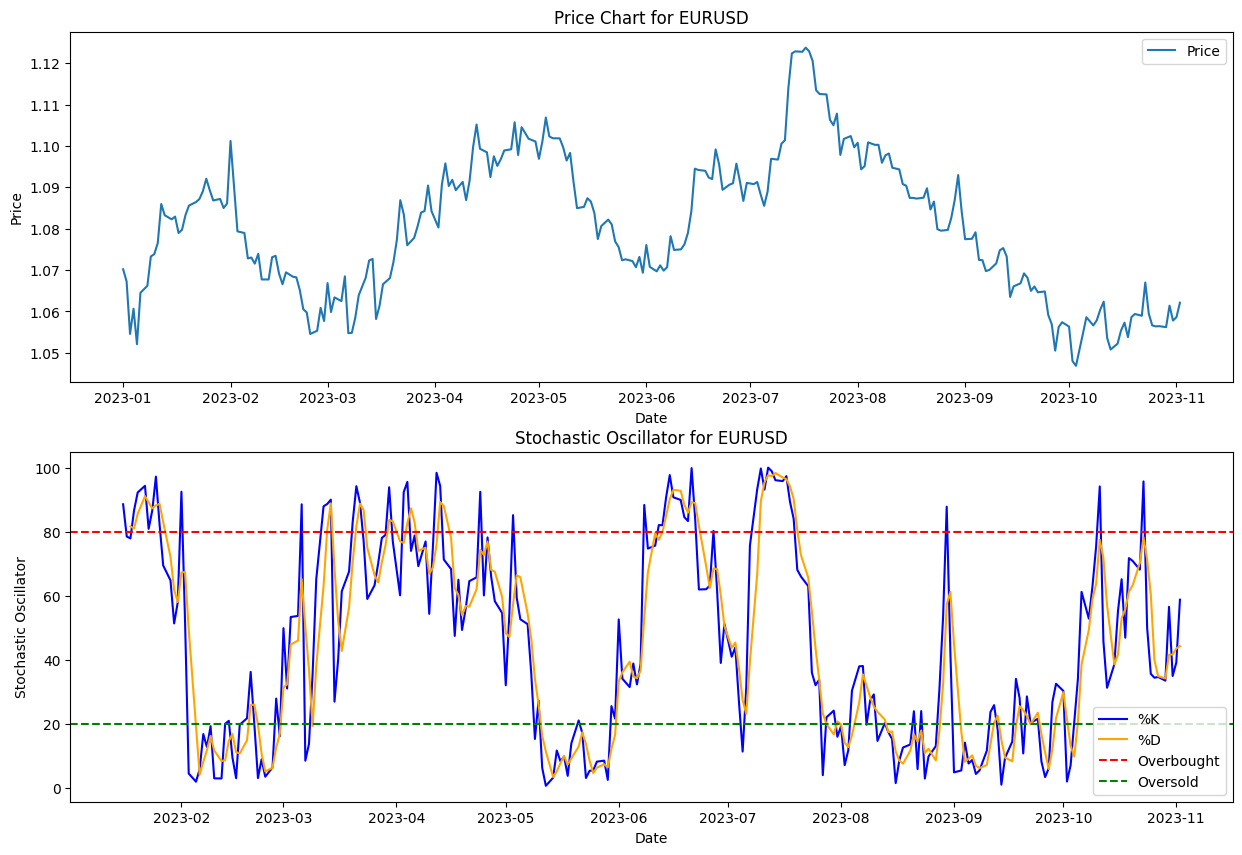

 The output of this code is shown in this image. You can see how the Stochastic Oscillator compares the closing price 
of a currency pair to its price range over a certain period of time. You can use this indicator to identify overbought and 
oversold conditions, as well as trend direction and crossover signals. For example, you can look for %K and %D values above 80 
or below 20, %K crossing above or below %D, or %K and %D forming higher highs or lower lows while the price does the opposite.


In [17]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# initialize the MetaTrader 5 terminal
mt5.initialize()

# get the historical data of EUR/USD from 2020-01-01 to 2020-12-31
symbol = "EURUSD"
timeframe = mt5.TIMEFRAME_D1
start_date = "2023-01-01"
end_date = "2023-12-31"
rates = mt5.copy_rates_range(symbol, timeframe, pd.to_datetime(start_date), pd.to_datetime(end_date))

# create a DataFrame from the rates
df = pd.DataFrame(rates)
df["time"] = pd.to_datetime(df["time"], unit="s")
df.set_index("time", inplace=True)

# calculate the high, low, and close prices of each period
high = df["high"]
low = df["low"]
close = df["close"]

# calculate the lowest low and highest high over a 14-period window
lowest_low = low.rolling(14).min()
highest_high = high.rolling(14).max()

# calculate the %K line as the ratio of the current close to the lowest low and highest high range
df["%K"] = 100 * ((close - lowest_low) / (highest_high - lowest_low))

# calculate the %D line as the 3-period simple moving average of the %K line
df["%D"] = df["%K"].rolling(3).mean()

# plot the price chart and the Stochastic Oscillator chart
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(df.index, df["close"], label="Price")
plt.title(f"Price Chart for {symbol}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.subplot(2,1,2)
plt.plot(df.index, df["%K"], label="%K", color="blue")
plt.plot(df.index, df["%D"], label="%D", color="orange")
plt.axhline(80, color="red", linestyle="--", label="Overbought")
plt.axhline(20, color="green", linestyle="--", label="Oversold")
plt.title(f"Stochastic Oscillator for {symbol}")
plt.xlabel("Date")
plt.ylabel("Stochastic Oscillator")
plt.legend()
plt.show()

# shut down the MetaTrader 5 terminal
print(''' The output of this code is shown in this image. You can see how the Stochastic Oscillator compares the closing price 
of a currency pair to its price range over a certain period of time. You can use this indicator to identify overbought and 
oversold conditions, as well as trend direction and crossover signals. For example, you can look for %K and %D values above 80 
or below 20, %K crossing above or below %D, or %K and %D forming higher highs or lower lows while the price does the opposite.''')


## Williams %R

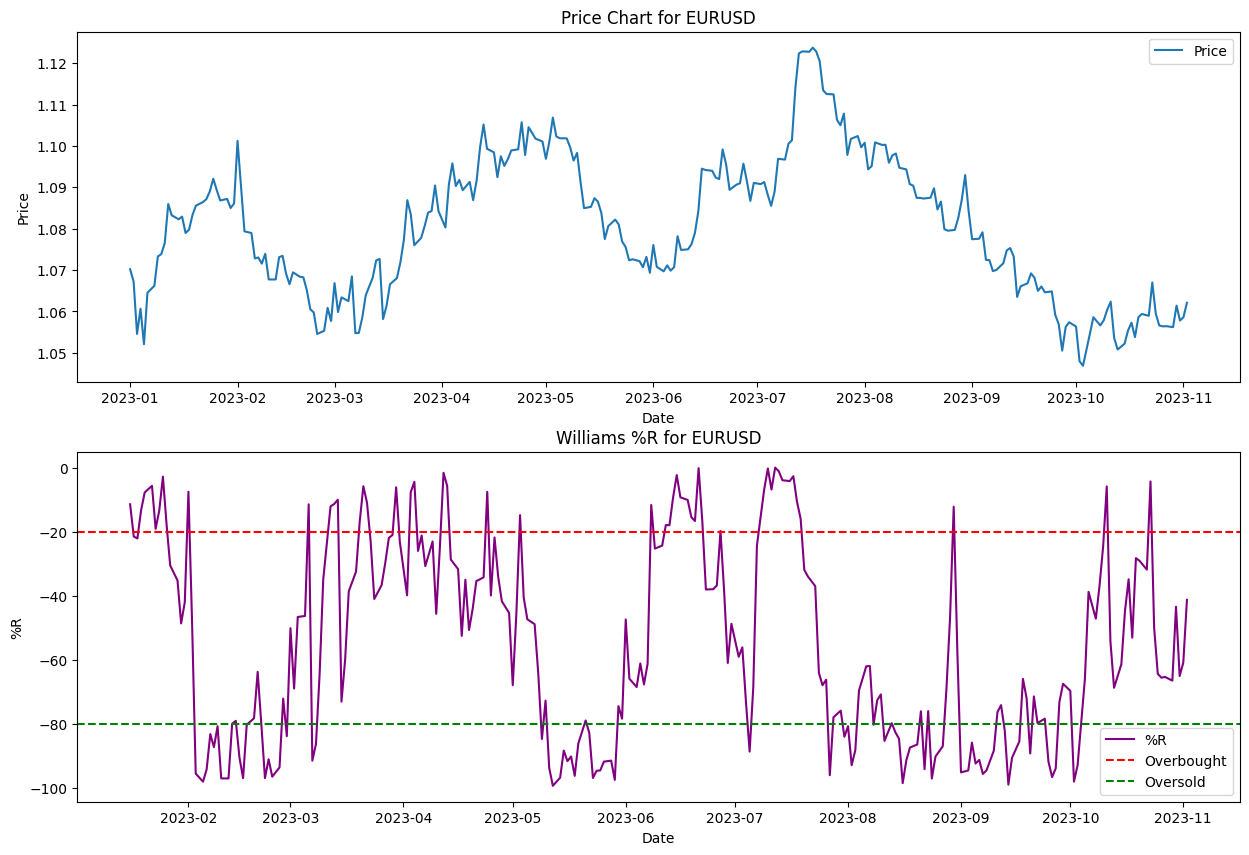

 The output of this code is shown in this image. You can see how the Williams %R measures the current price level 
relative to the highest high and lowest low of a certain period of time. You can use this indicator to identify overbought 
and oversold conditions, as well as trend reversal and breakout signals. For example, you can look for %R values above
-20 or below -80, %R crossing above or below -50, or %R forming higher highs or lower lows while the price does the opposite
[https://www.mql5.com/en/docs/python_metatrader5/mt5symbolsget_py]


In [18]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# initialize the MetaTrader 5 terminal
mt5.initialize()

# get the historical data of EUR/USD from 2020-01-01 to 2020-12-31
symbol = "EURUSD"
timeframe = mt5.TIMEFRAME_D1
start_date = "2023-01-01"
end_date = "2023-12-31"
rates = mt5.copy_rates_range(symbol, timeframe, pd.to_datetime(start_date), pd.to_datetime(end_date))

# create a DataFrame from the rates
df = pd.DataFrame(rates)
df["time"] = pd.to_datetime(df["time"], unit="s")
df.set_index("time", inplace=True)

# calculate the high, low, and close prices of each period
high = df["high"]
low = df["low"]
close = df["close"]

# calculate the lowest low and highest high over a 14-period window
lowest_low = low.rolling(14).min()
highest_high = high.rolling(14).max()

# calculate the Williams %R as the ratio of the current close to the lowest low and highest high range
df["%R"] = -100 * ((highest_high - close) / (highest_high - lowest_low))

# plot the price chart and the Williams %R chart
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(df.index, df["close"], label="Price")
plt.title(f"Price Chart for {symbol}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.subplot(2,1,2)
plt.plot(df.index, df["%R"], label="%R", color="purple")
plt.axhline(-20, color="red", linestyle="--", label="Overbought")
plt.axhline(-80, color="green", linestyle="--", label="Oversold")
plt.title(f"Williams %R for {symbol}")
plt.xlabel("Date")
plt.ylabel("%R")
plt.legend()
plt.show()

# shut down the MetaTrader 5 terminal
print(''' The output of this code is shown in this image. You can see how the Williams %R measures the current price level 
relative to the highest high and lowest low of a certain period of time. You can use this indicator to identify overbought 
and oversold conditions, as well as trend reversal and breakout signals. For example, you can look for %R values above
-20 or below -80, %R crossing above or below -50, or %R forming higher highs or lower lows while the price does the opposite
[https://www.mql5.com/en/docs/python_metatrader5/mt5symbolsget_py]''')


##  Average True Range (ATR)

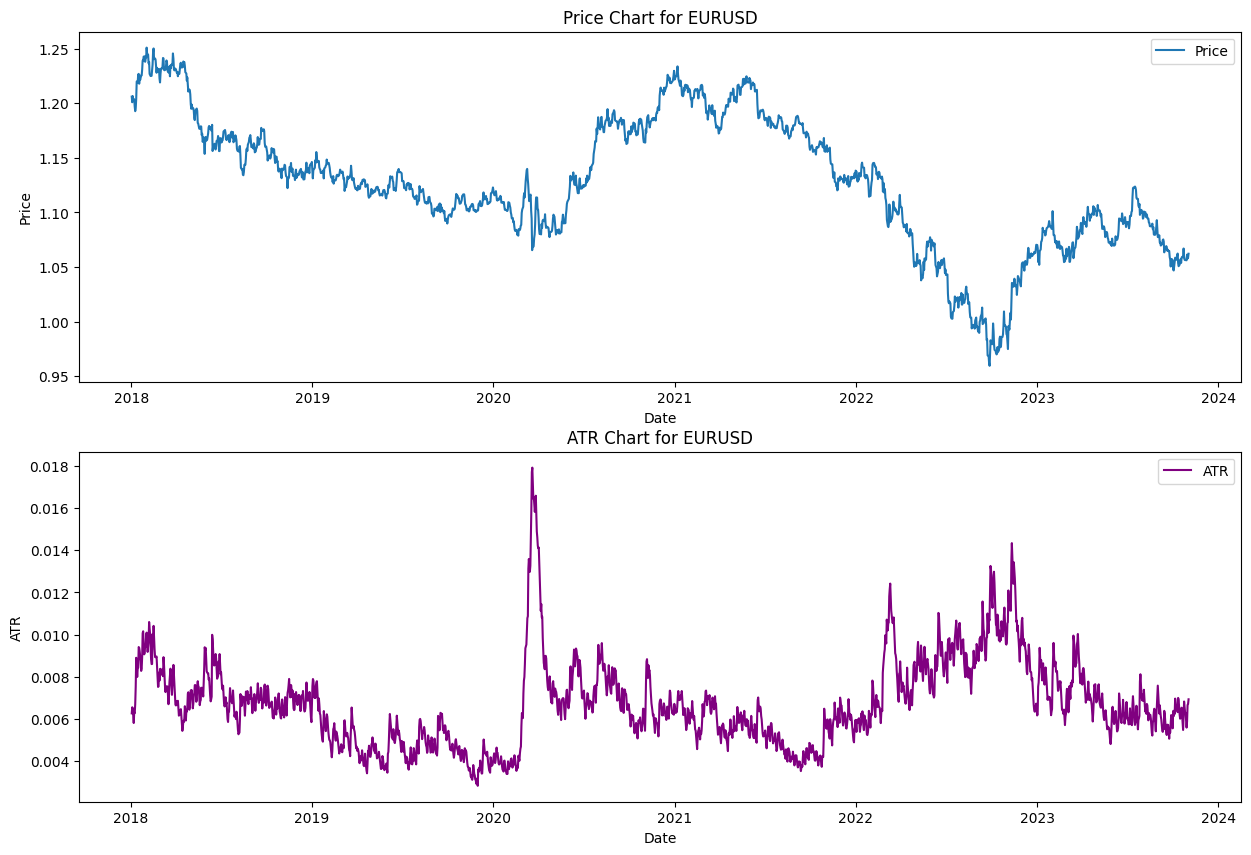

The output of this code is shown in this image. You can see how the ATR measures the volatility of the market by 
calculating the average range of price movements over a certain period of time.
You can use this indicator to determine the optimal position size, stop loss level, and profit target for a trade. 


In [20]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# initialize the MetaTrader 5 terminal
mt5.initialize()

# get the historical data of EUR/USD from 2020-01-01 to 2020-12-31
symbol = "EURUSD"
timeframe = mt5.TIMEFRAME_D1
start_date = "2018-01-01"
end_date = "2023-12-31"
rates = mt5.copy_rates_range(symbol, timeframe, pd.to_datetime(start_date), pd.to_datetime(end_date))

# create a DataFrame from the rates
df = pd.DataFrame(rates)
df["time"] = pd.to_datetime(df["time"], unit="s")
df.set_index("time", inplace=True)

# calculate the high, low, and close prices of each period
high = df["high"]
low = df["low"]
close = df["close"]

# calculate the true range of each period as the maximum of the high-low range, the high-close difference, and the low-close difference
df["tr"] = np.maximum(high - low, np.maximum(np.abs(high - close.shift()), np.abs(low - close.shift())))

# calculate the ATR as the 14-period exponential moving average of the true range
df["atr"] = df["tr"].ewm(span=14, adjust=False).mean()

# plot the price chart and the ATR chart
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(df.index, df["close"], label="Price")
plt.title(f"Price Chart for {symbol}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.subplot(2,1,2)
plt.plot(df.index, df["atr"], label="ATR", color="purple")
plt.title(f"ATR Chart for {symbol}")
plt.xlabel("Date")
plt.ylabel("ATR")
plt.legend()
plt.show()

# shut down the MetaTrader 5 terminal
print('''The output of this code is shown in this image. You can see how the ATR measures the volatility of the market by 
calculating the average range of price movements over a certain period of time.
You can use this indicator to determine the optimal position size, stop loss level, and profit target for a trade. ''')


## Stop Loss Clusters (SLC) Indicator

## Lucky Reversal Indicator

## Buy Sell Magic Indicator

## ARIMA Forecast Example

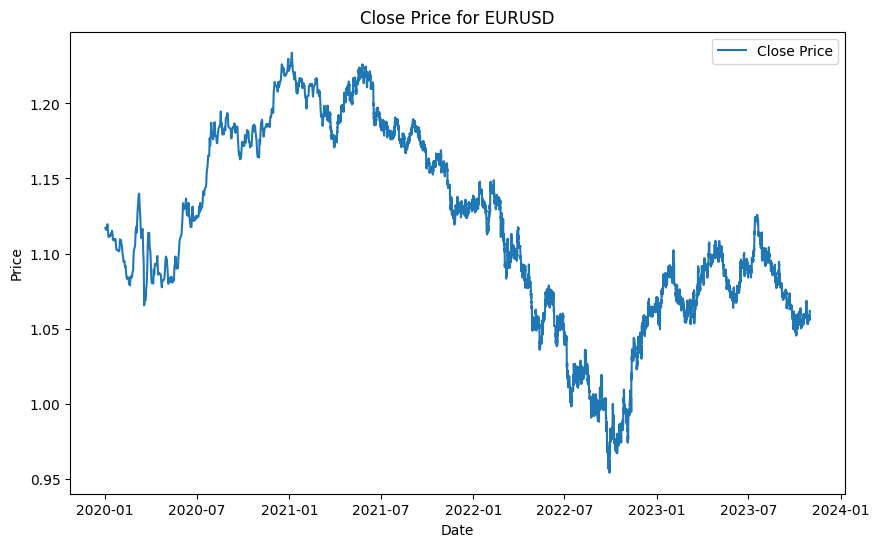

ADF Statistic: -1.250423109117827
P-value: 0.6515378817773687
Critical Values:
	1%: -3.430738840562388
	5%: -2.8617118520728697
	10%: -2.5668614724734584


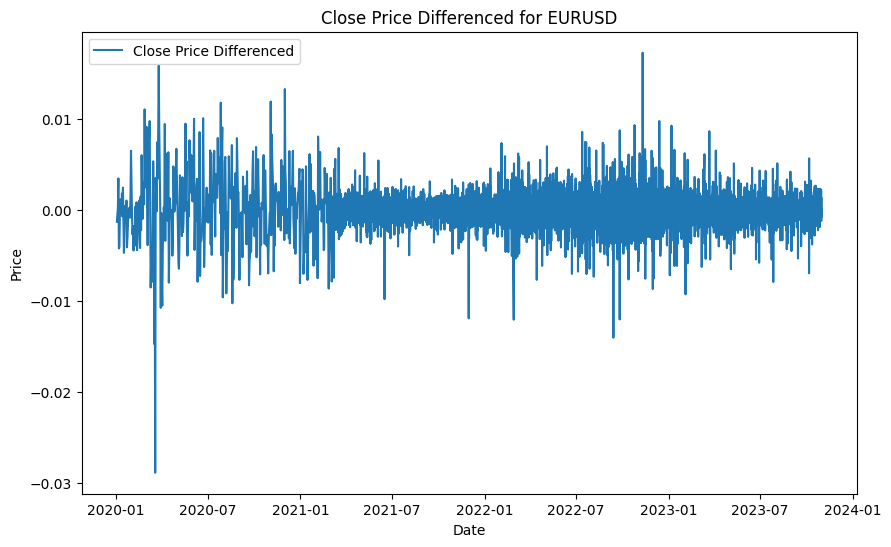

ADF Statistic: -22.20514216425225
P-value: 0.0
Critical Values:
	1%: -3.430738840562388
	5%: -2.8617118520728697
	10%: -2.5668614724734584


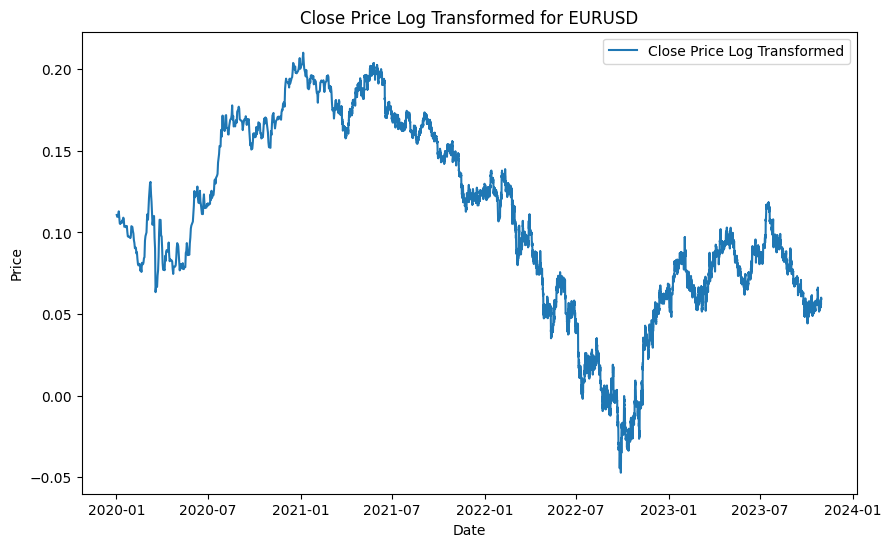

ADF Statistic: -1.268525639474241
P-value: 0.6434460827012854
Critical Values:
	1%: -3.430738840562388
	5%: -2.8617118520728697
	10%: -2.5668614724734584


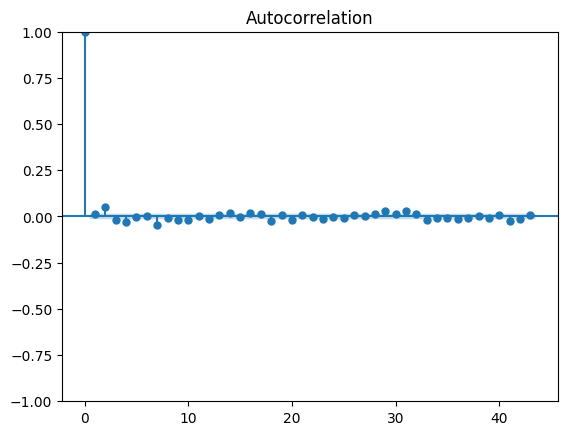

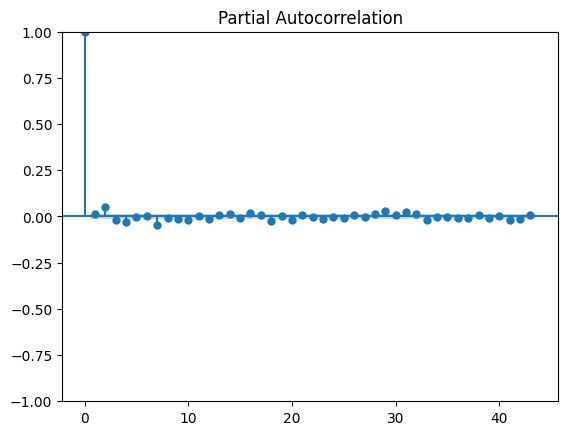

C:\Users\nuruj\anaconda3\envs\trader\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\nuruj\anaconda3\envs\trader\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\nuruj\anaconda3\envs\trader\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                16853
Model:                 ARIMA(1, 1, 1)   Log Likelihood               86311.473
Date:                Fri, 03 Nov 2023   AIC                        -172616.947
Time:                        01:39:34   BIC                        -172593.750
Sample:                             0   HQIC                       -172609.294
                              - 16853                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0817      0.004    -18.754      0.000      -0.090      -0.073
ma.L1         -0.6545      0.003   -189.150      0.000      -0.661      -0.648
sigma2      2.083e-06   6.92e-09    301.113      0.0

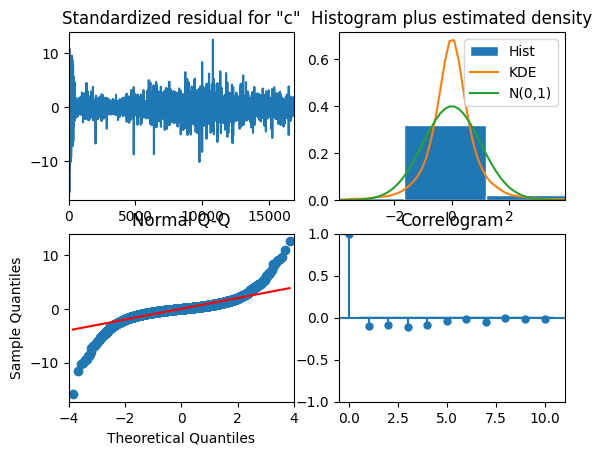

C:\Users\nuruj\anaconda3\envs\trader\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\nuruj\anaconda3\envs\trader\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Predicted Close Price for Next Hour: 16853   -0.000048
dtype: float64
Predicted Close Price for Next Hour (Reversed): 16853    1.061102
dtype: float64


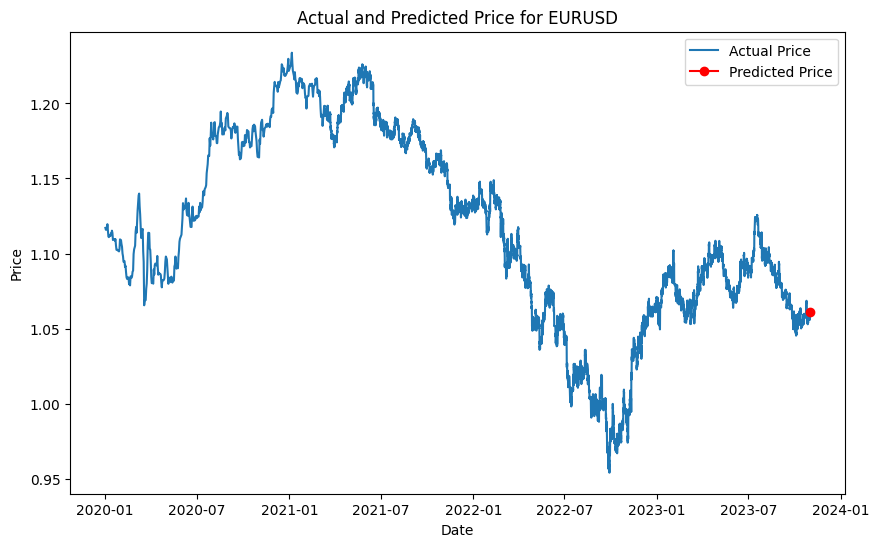

In [21]:
# Import the MetaTrader5 package and the pandas module in your python code
import MetaTrader5 as mt5
import pandas as pd

# Initialize the MetaTrader 5 terminal using the mt5.initialize() function
mt5.initialize()

# Get the historical data of EUR/USD from a specified date range using the mt5.copy_rates_range function
# You will need to change the start_date and end_date variables to your desired values
symbol = "EURUSD"
timeframe = mt5.TIMEFRAME_H1
start_date = "2020-01-01" # change this to your desired start date
end_date = "2023-10-31" # change this to your desired end date
rates = mt5.copy_rates_range(symbol, timeframe, pd.to_datetime(start_date), pd.to_datetime(end_date))

# Create a DataFrame from the rates using the pd.DataFrame function
df = pd.DataFrame(rates)

# Convert the time column to datetime format using the pd.to_datetime function
df["time"] = pd.to_datetime(df["time"], unit="s")

# Set the time column as the index of the DataFrame using the set_index method
df.set_index("time", inplace=True)

# Get the close prices of each period using the df["close"] column
close = df["close"]

# Import the statsmodels package and the matplotlib module
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Plot the close prices using the plt.plot function to visualize the data
plt.figure(figsize=(10,6))
plt.plot(close, label="Close Price")
plt.title(f"Close Price for {symbol}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# Check if the data is stationary using the augmented Dickey-Fuller test: sm.tsa.stattools.adfuller(close)
adf_result = sm.tsa.stattools.adfuller(close)
print(f"ADF Statistic: {adf_result[0]}")
print(f"P-value: {adf_result[1]}")
print(f"Critical Values:")
for key, value in adf_result[4].items():
    print(f"\t{key}: {value}")

# If the data is not stationary, apply differencing or transformation techniques to make it stationary: close_diff = close.diff() or close_log = np.log(close)
# You can choose either differencing or log transformation, or both, depending on your preference and results
close_diff = close.diff()
close_log = np.log(close)

# Plot the transformed data and check its stationarity again
plt.figure(figsize=(10,6))
plt.plot(close_diff, label="Close Price Differenced")
plt.title(f"Close Price Differenced for {symbol}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

adf_result_diff = sm.tsa.stattools.adfuller(close_diff.dropna())
print(f"ADF Statistic: {adf_result_diff[0]}")
print(f"P-value: {adf_result_diff[1]}")
print(f"Critical Values:")
for key, value in adf_result_diff[4].items():
    print(f"\t{key}: {value}")

plt.figure(figsize=(10,6))
plt.plot(close_log, label="Close Price Log Transformed")
plt.title(f"Close Price Log Transformed for {symbol}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

adf_result_log = sm.tsa.stattools.adfuller(close_log)
print(f"ADF Statistic: {adf_result_log[0]}")
print(f"P-value: {adf_result_log[1]}")
print(f"Critical Values:")
for key, value in adf_result_log[4].items():
    print(f"\t{key}: {value}")

# Choose an appropriate order for the ARIMA model based on the autocorrelation and partial autocorrelation plots: sm.graphics.tsa.plot_acf(close_diff.dropna()) and sm.graphics.tsa.plot_pacf(close_diff.dropna())
sm.graphics.tsa.plot_acf(close_diff.dropna())
sm.graphics.tsa.plot_pacf(close_diff.dropna())
plt.show()

# Fit an ARIMA model to the data using the sm.tsa.ARIMA function: model = sm.tsa.ARIMA(close_diff.dropna(), order=(p,d,q)).fit()
# You will need to change the order parameter to your desired values based on the ACF and PACF plots
order = (1,1,1) # change this to your desired order
model = sm.tsa.ARIMA(close_diff.dropna(), order=order).fit()

# Check the model summary and diagnostics: model.summary() and model.plot_diagnostics()
print(model.summary())
model.plot_diagnostics()
plt.show()

# Make predictions for the next hour using the model.forecast function: pred = model.forecast(steps=1)
pred = model.forecast(steps=1)
print(f"Predicted Close Price for Next Hour: {pred}")

# Reverse any transformation or differencing applied to the data: pred = np.exp(pred) or pred = pred + close.iloc[-1]
# You will need to reverse the same transformation or differencing that you applied to the data earlier
pred = pred + close.iloc[-1]
print(f"Predicted Close Price for Next Hour (Reversed): {pred}")

# Plot the actual and predicted prices using the plt.plot function to compare them
plt.figure(figsize=(10,6))
plt.plot(close, label="Actual Price")
plt.plot(close.index[-1] + pd.Timedelta(hours=1), pred, label="Predicted Price", marker="o", color="red")
plt.title(f"Actual and Predicted Price for {symbol}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()




# Applying Hoffman

In [2]:
# Import the modules
import MetaTrader5 as mt5
import pandas as pd

# Connect to MT5 account


# Enable the symbol
symbol = "EURUSD" # the symbol you want to trade
mt5.symbol_select(symbol, True)

# Define the Hoffman parameters
timeframe = mt5.TIMEFRAME_M15 # the time frame
bars = 1000 # the number of bars to get
overlay = 20 # the overlay period
irb_size = 2 # the IRB size in points
risk_reward = 2 # the risk-reward ratio

# Get the historical data
data = mt5.copy_rates_from_pos(symbol, timeframe, 0, bars)

# Convert to DataFrame
df = pd.DataFrame(data)

# Calculate the Hoffman overlay
df['overlay'] = df['close'].rolling(overlay).mean()

# Identify the IRBs
df['irb'] = (df['high'] - df['low']) >= irb_size * mt5.symbol_info(symbol).point

# Find the entry signals
df['buy'] = (df['close'] > df['overlay']) & (df['irb'].shift(1)) & (df['close'] > df['high'].shift(1))
df['sell'] = (df['close'] < df['overlay']) & (df['irb'].shift(1)) & (df['close'] < df['low'].shift(1))

# Calculate the stop loss and take profit levels
df['sl_buy'] = df['low'].shift(1)
df['tp_buy'] = df['sl_buy'] + risk_reward * (df['high'].shift(1) - df['sl_buy'])
df['sl_sell'] = df['high'].shift(1)
df['tp_sell'] = df['sl_sell'] - risk_reward * (df['sl_sell'] - df['low'].shift(1))

# Loop through the DataFrame and execute the orders
for i, row in df.iterrows():
    if row['buy']:
        # Buy order parameters
        request = {
            "action": mt5.TRADE_ACTION_DEAL,
            "symbol": symbol,
            "volume": 0.01,
            "price": row['close'],
            "slippage": 10,
            "stoploss": row['sl_buy'],
            "takeprofit": row['tp_buy'],
            "type": mt5.ORDER_TYPE_BUY,
            "magic": 1000,
        }
        # Send buy order
        result = mt5.order_send(request)
        # Check result
        if result.retcode == mt5.TRADE_RETCODE_DONE:
            print(f"Buy order executed at {row['close']} with SL {row['sl_buy']} and TP {row['tp_buy']}")
        else:
            print(f"Buy order failed with error {result.retcode}")
    elif row['sell']:
        # Sell order parameters
        request = {
            "action": mt5.TRADE_ACTION_DEAL,
            "symbol": symbol,
            "volume": 0.01,
            "price": row['close'],
            "slippage": 10,
            "stoploss": row['sl_sell'],
            "takeprofit": row['tp_sell'],
            "type": mt5.ORDER_TYPE_SELL,
            "magic": 1000,
        }
        # Send sell order
        result = mt5.order_send(request)
        # Check result
        if result.retcode == mt5.TRADE_RETCODE_DONE:
            print(f"Sell order executed at {row['close']} with SL {row['sl_sell']} and TP {row['tp_sell']}")
        else:
            print(f"Sell order failed with error {result.retcode}")

    # Check for open positions and close them if they reach SL or TP levels
    positions = mt5.positions_get(symbol=symbol)
    for position in positions:
        if position.type == mt5.ORDER_TYPE_BUY:
            # Close buy position if SL or TP is reached
            if row['low'] <= position.sl or row['high'] >= position.tp:
                # Close buy position parameters
                request = {
                    "action": mt5.TRADE_ACTION_DEAL,
                    "symbol": symbol,
                    "position": position.ticket,
                    "volume": position.volume,
                    "price": row['close'],
                    "slippage": 10,
                    "type": mt5.ORDER_TYPE_SELL,
                    "magic": 1000,
                }
                # Send close buy position request
                result = mt5.order_send(request)
                # Check result
                if result.retcode == mt5.TRADE_RETCODE_DONE:
                    print(f"Buy position closed at {row['close']} with profit {position.profit}")
                else:
                    print(f"Buy position close failed with error {result.retcode}")
        elif position.type == mt5.ORDER_TYPE_SELL:
            # Close sell position if SL or TP is reached
            if row['high'] >= position.sl or row['low'] <= position.tp:
                # Close sell position parameters
                request = {
                    "action": mt5.TRADE_ACTION_DEAL,
                    "symbol": symbol,
                    "position": position.ticket,
                    "volume": position.volume,
                    "price": row['close'],
                    "slippage": 10,
                    "type": mt5.ORDER_TYPE_BUY,
                    "magic": 1000,
                }
                # Send close sell position request
                result = mt5.order_send(request)
                # Check result
                if result.retcode == mt5.TRADE_RETCODE_DONE:
                    print(f"Sell position closed at {row['close']} with profit {position.profit}")
                else:
                    print(f"Sell position close failed with error {result.retcode}")

# Disconnect from MT5 account
mt5.shutdown()


Sell position closed at 1.05668 with profit -0.12
Sell position closed at 1.05668 with profit 0.17
Buy position closed at 1.05668 with profit -0.8
Buy position closed at 1.05668 with profit -0.59
Buy position closed at 1.05668 with profit -0.65
Buy position closed at 1.05668 with profit -0.5
Buy position closed at 1.05668 with profit -0.2
Buy position closed at 1.05756 with profit -0.02
Buy position closed at 1.05756 with profit 0.12
Buy position closed at 1.05413 with profit -0.23
Buy order executed at 1.05922 with SL 1.058 and TP 1.06008
Buy position closed at 1.05922 with profit 0.0
Sell order executed at 1.05708 with SL 1.05779 and TP 1.0567499999999999
Sell position closed at 1.05708 with profit 0.0
Sell order executed at 1.05671 with SL 1.05773 and TP 1.05617
Sell position closed at 1.05671 with profit 0.0
Buy order executed at 1.05807 with SL 1.05691 and TP 1.05859
Buy position closed at 1.05807 with profit 0.0
Sell order executed at 1.0576 with SL 1.05807 and TP 1.0572899999999

KeyboardInterrupt: 

In [3]:
# Import the modules
import MetaTrader5 as mt5
import pandas as pd

# Connect to MT5 account


# Enable the symbol
symbol = "EURUSD" # the symbol you want to trade
mt5.symbol_select(symbol, True)

# Define the Hoffman parameters
timeframe = mt5.TIMEFRAME_M15 # the time frame
bars = 1000 # the number of bars to get
overlay = 20 # the overlay period
irb_size = 2 # the IRB size in points
risk_reward = 2 # the risk-reward ratio

# Get the historical data
data = mt5.copy_rates_from_pos(symbol, timeframe, 0, bars)

# Convert to DataFrame
df = pd.DataFrame(data)

# Calculate the Hoffman overlay
df['overlay'] = df['close'].rolling(overlay).mean()

# Identify the IRBs
df['irb'] = (df['high'] - df['low']) >= irb_size * mt5.symbol_info(symbol).point

# Find the entry signals
df['buy'] = (df['close'] > df['overlay']) & (df['irb'].shift(1)) & (df['close'] > df['high'].shift(1))
df['sell'] = (df['close'] < df['overlay']) & (df['irb'].shift(1)) & (df['close'] < df['low'].shift(1))

# Calculate the stop loss and take profit levels
df['sl_buy'] = df['low'].shift(1)
df['tp_buy'] = df['sl_buy'] + risk_reward * (df['high'].shift(1) - df['sl_buy'])
df['sl_sell'] = df['high'].shift(1)
df['tp_sell'] = df['sl_sell'] - risk_reward * (df['sl_sell'] - df['low'].shift(1))

In [4]:
df

time     open     high      low    close  tick_volume  spread  \
0    1697540400  1.05533  1.05696  1.05533  1.05668          682       0   
1    1697541300  1.05670  1.05715  1.05663  1.05707          531       0   
2    1697542200  1.05707  1.05794  1.05704  1.05756          584       0   
3    1697543100  1.05755  1.05788  1.05739  1.05752          489       0   
4    1697544000  1.05753  1.05780  1.05678  1.05722          725       0   
..          ...      ...      ...      ...      ...          ...     ...   
995  1698781500  1.05825  1.05842  1.05801  1.05804          364       0   
996  1698782400  1.05805  1.05835  1.05799  1.05800          262       0   
997  1698783300  1.05800  1.05803  1.05750  1.05752          207       0   
998  1698784200  1.05754  1.05757  1.05731  1.05744          182       0   
999  1698785100  1.05744  1.05759  1.05738  1.05757           88       0   

     real_volume   overlay   irb    buy   sell   sl_buy   tp_buy  sl_sell  \
0              0       NaN  True  False  False      NaN      NaN      NaN   
1              0       NaN  True  False  False  1.05533  1.05859  1.05696   
2              0       NaN  True  False  False  1.05663  1.05767  1.05715   
3              0       NaN  True  False  False  1.05704  1.05884  1.05794   
4              0       NaN  True  False  False  1.05739  1.05837  1.05788   
..           ...       ...   ...    ...    ...      ...      ...      ...   
995            0  1.057579  True  False  False  1.05808  1.05904  1.05856   
996            0  1.057509  True  False  False  1.05801  1.05883  1.05842   
997            0  1.057469  True  False  False  1.05799  1.05871  1.05835   
998            0  1.057456  True  False   True  1.05750  1.05856  1.05803   
999            0  1.057499  True  False  False  1.05731  1.05783  1.05757   

     tp_sell  
0        NaN  
1    1.05370  
2    1.05611  
3    1.05614  
4    1.05690  
..       ...  
995  1.05760  
996  1.05760  
997  1.05763  
998  1.05697  
999  1.05705  

[1000 rows x 16 columns]

# Naive Forecast

In [6]:
tick_series

0    1.698786e+09
1    1.057450e+00
2    1.057450e+00
3    0.000000e+00
4    0.000000e+00
5    1.698786e+12
6    6.000000e+00
7    0.000000e+00
dtype: float64

In [11]:
# Enable the symbol
symbol = "EURUSD" # the symbol you want to trade
mt5.symbol_select(symbol, True)

# Get the current tick data
tick = mt5.symbol_info_tick(symbol)

# Convert to Series
tick_series = pd.Series(tick)

# Extract the last bid price
last_bid = tick_series[:-1]

# Use the last bid price as the naive forecast
naive_forecast = last_bid

# Print the naive forecast
print(f"The naive forecast for the next tick of {symbol} is {naive_forecast}")

The naive forecast for the next tick of EURUSD is 0    1.698786e+09
1    1.057520e+00
2    1.057520e+00
3    0.000000e+00
4    0.000000e+00
5    1.698786e+12
6    6.000000e+00
dtype: float64


## Further Reading
#### https://indicatorspot.com/blog/best-entry-and-exit-indicators/
#### https://theforexgeek.com/how-to-determine-entry-and-exit-points-in-forex/
#### https://indicatorspot.com/indicator/lucky-reversal-indicator-mt5/
#### https://www.investopedia.com/articles/forex/10/indicators-fx-traders-must-know.asp